### Επίδραση του Αριθμού των Δωρεάν Αδειών στα Κέρδη και άλλες Μεταβλητές των Επιχειρήσεων

**Πείραμα:**
- Emission cap = 70%, 80%, 90% BAU emissions
- 9 εταιρείες
- 3 τομείς
  - Ο 3ος τομέας έχει **πολύ μεγάλο** μέγεθος σε όρους πωλήσεων

**Διαδικασία:**
Δίνουμε σταδιακά περισσότερες δωρεάν άδειες στις 3 εταιρείες του 1ου τομέα και παρατηρούμε τις επιπτώσεις στα κέρδη και άλλες μεταβλητές. Στον 2ο τομέα, δεν δίνονται δωρεάν άδειες.

- Δωρεάν άδειες στον 1ο τομέα: από 0 έως την ποσότητα παραγωγής (q).


In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from funkwpap import *
import sympy as sp, pandas as pd, numpy as np, tqdm, time, sys, matplotlib.pyplot as plt, tqdm
from statistics import mean
from scipy.optimize import fsolve
from random import random


In [2]:
x = sp.symbols('x')
cap = 2000 # total emission cap
Regulator22 = Regulator("test1", permit_price = 2.4079, emission_cap = cap)
sector1 = Sector('cement', price_demand_function= 100 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator22)
sector2 = Sector('steel', price_demand_function=150 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator22)
sector3 = Sector('paper', price_demand_function= 200 - 0.02*x**1.5, free_emission_multiplier= 0, regulator= Regulator22)
country1 = Country('DE', 1, regulator= Regulator22)
country2 = Country('FI', 0.5, regulator= Regulator22)
country3 = Country('GR', size= 0.1, regulator= Regulator22)

# Create Firms using objects
firm1 = Firm('firm1', 1, 1, x*0, 10*x+ 2*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator22)
firm2 = Firm('firm2', 1, 2, x*0, 11*x+ 3*x**2 + 2*x**3, 0, 0, 0, regulator= Regulator22)
firm3 = Firm('firm3', 1, 3, x*0, 5*x+ 4*x**2 + 5*x**3 , 0, 0, 0, regulator= Regulator22)
firm4 = Firm('firm4', 2, 1, x*0, 7*x+ 5*x**2 + 3*x**3 , 0, 0, 0, regulator= Regulator22)
firm5 = Firm('firm5', 2, 2, x*0, 1*x+ 6*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator22)
firm6 = Firm('firm6', 2, 3, x*0, 2*x+ 7*x**2 + 3*x**3 , 0, 0, 0, regulator= Regulator22)
firm7 = Firm('firm7', 3, 1, x*0, 3*x+ 8*x**2 + 4*x**3 , 0, 0, 0, regulator= Regulator22)
firm8 = Firm('firm8', 3, 2, x*0, 4*x+ 9*x**2 + 10*x**3 , 0, 0, 0, regulator= Regulator22)
firm9 = Firm('firm9', 3, 3, x*0, 5*x+ 10*x**2 + 11*x**3 , 0, 0, 0, regulator= Regulator22)



In [3]:
Regulator22.BAU_calculator()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-14


In [8]:
# Define the percentages of BAU emissions
bau_percentages = [0.7, 0.8, 0.9]


# Initialize dictionaries to store results for each percentage
results = {perc: {
    'profits1': [], 'profits2': [], 'abatements1': [], 'abatements2': [],
    'trades1': [], 'trades2': [], 'permits_bought_1': [], 'permits_bought_2': [],
    'permits_free_1': [], 'permits_free_2': [], 'permits_used_1': [], 'permits_used_2': [],
    'revenews1': [], 'revenews2': [], 'permit_price': [],
    'outputs1': [], 'outputs2': [], 'emissions1': [], 'emissions2': [],
    'consumer_surplus_1' : [], 'consumer_surplus_2' : []
} for perc in bau_percentages}

# Loop over each percentage
for perc in bau_percentages:
    Regulator22.emission_cap = Regulator22.BAU_emissions * perc
    frees = np.linspace(0, 1, 100)

    for free in tqdm.tqdm(frees):
        sector1.free_emission_multiplier = free
        Regulator22.optimization_concave_formulation_ab()
        print(f"{free}: {Regulator22.equilibrium_tester(output=True, precision = 0.1)}")

        for firm in Regulator22.firm_registry.values():
            firm.calculate_profit_components()

        results[perc]['profits1'].append(mean(float(i.profit) for i in sector1.firms))
        results[perc]['profits2'].append(mean(float(i.profit) for i in sector2.firms + sector3.firms))
        results[perc]['abatements1'].append(mean(float(i.abatement) for i in sector1.firms))
        results[perc]['abatements2'].append(mean(float(i.abatement) for i in sector2.firms + sector3.firms))
        results[perc]['trades1'].append(mean(float(i.permits_costs) for i in sector1.firms))
        results[perc]['trades2'].append(mean(float(i.permits_costs) for i in sector2.firms + sector3.firms))
        results[perc]['revenews1'].append(mean(float(i.sales) for i in sector1.firms))
        results[perc]['revenews2'].append(mean(float(i.sales) for i in sector2.firms + sector3.firms))
        results[perc]['permit_price'].append(Regulator22.permit_price)
        results[perc]['outputs1'].append(mean(float(i.actual_output) for i in sector1.firms))
        results[perc]['outputs2'].append(mean(float(i.actual_output) for i in sector2.firms + sector3.firms))
        results[perc]['emissions1'].append(mean(float(i.emission) for i in sector1.firms))
        results[perc]['emissions2'].append(mean(float(i.emission) for i in sector2.firms + sector3.firms))
        results[perc]['consumer_surplus_1'].append(sector1.get_consumer_surplus())
        results[perc]['consumer_surplus_2'].append((sector2.get_consumer_surplus() + sector3.get_consumer_surplus())/2)
        results[perc]['permits_used_1'].append(mean( float(i.permits_used) for i in sector1.firms))
        results[perc]['permits_used_2'].append(mean( float(i.permits_used) for i in sector2.firms + sector3.firms))
        results[perc]['permits_free_1'].append(mean( float(i.free_permits) for i in sector1.firms))
        results[perc]['permits_free_2'].append(mean( float(i.free_permits) for i in sector2.firms + sector3.firms))
        results[perc]['permits_bought_1'].append(mean( float(i.permits_bought) for i in sector1.firms))
        results[perc]['permits_bought_2'].append(mean( float(i.permits_bought) for i in sector2.firms + sector3.firms))

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:02<04:29,  2.72s/it]

Optimal solution found
Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0053 ✔️ |  +2.87e-5 ✔️ |  -27.2236 ✔️ |  -27.4236 ✔️ |   +5.4447 ✔️ | 5/5
0.0: (True, 0.00530363666130285)


  2%|▏         | 2/100 [00:05<04:16,  2.62s/it]

Optimal solution found
Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0073 ✔️ |  +8.31e-6 ✔️ |  -27.3055 ✔️ |  -27.5055 ✔️ |   +5.4611 ✔️ | 5/5
0.010101010101010102: (True, 0.00726826673457026)


  3%|▎         | 3/100 [00:08<04:40,  2.90s/it]

Optimal solution found
Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0092 ✔️ |  +7.90e-6 ✔️ |  -27.3879 ✔️ |  -27.5879 ✔️ |   +5.4776 ✔️ | 5/5
0.020202020202020204: (True, 0.00924134879843308)
Optimal solution found


  4%|▍         | 4/100 [00:10<04:01,  2.51s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0112 ✔️ |  +4.60e-6 ✔️ |  -27.4709 ✔️ |  -27.6709 ✔️ |   +5.4942 ✔️ | 5/5
0.030303030303030304: (True, 0.0111860896341724)
Optimal solution found


  5%|▌         | 5/100 [00:13<04:16,  2.70s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0131 ✔️ |  +2.94e-6 ✔️ |  -27.5543 ✔️ |  -27.7543 ✔️ |   +5.5109 ✔️ | 5/5
0.04040404040404041: (True, 0.0131063694001874)
Optimal solution found


  6%|▌         | 6/100 [00:16<04:19,  2.76s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0150 ✔️ |  +4.38e-6 ✔️ |  -27.6383 ✔️ |  -27.8383 ✔️ |   +5.5277 ✔️ | 5/5
0.05050505050505051: (True, 0.0150089653349781)
Optimal solution found


  7%|▋         | 7/100 [00:18<04:13,  2.72s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0169 ✔️ |  +5.80e-6 ✔️ |  -27.7228 ✔️ |  -27.9228 ✔️ |   +5.5446 ✔️ | 5/5
0.06060606060606061: (True, 0.0168746958969059)
Optimal solution found


  8%|▊         | 8/100 [00:22<04:25,  2.88s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0187 ✔️ |  +1.45e-5 ✔️ |  -27.8079 ✔️ |  -28.0079 ✔️ |   +5.5616 ✔️ | 5/5
0.07070707070707072: (True, 0.0187165868602079)
Optimal solution found


  9%|▉         | 9/100 [00:25<04:28,  2.95s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0205 ✔️ |  +1.10e-5 ✔️ |  -27.8935 ✔️ |  -28.0935 ✔️ |   +5.5787 ✔️ | 5/5
0.08080808080808081: (True, 0.0205406821596199)
Optimal solution found


 10%|█         | 10/100 [00:28<04:30,  3.01s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0223 ✔️ |  +2.54e-5 ✔️ |  -27.9797 ✔️ |  -28.1797 ✔️ |   +5.5959 ✔️ | 5/5
0.09090909090909091: (True, 0.0223144535944506)
Optimal solution found


 11%|█         | 11/100 [00:31<04:16,  2.88s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0241 ✔️ |  +2.05e-5 ✔️ |  -28.0664 ✔️ |  -28.2664 ✔️ |   +5.6133 ✔️ | 5/5
0.10101010101010102: (True, 0.0240665768766597)
Optimal solution found


 12%|█▏        | 12/100 [00:33<03:54,  2.66s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0258 ✔️ |  +1.54e-6 ✔️ |  -28.1537 ✔️ |  -28.3537 ✔️ |   +5.6307 ✔️ | 5/5
0.11111111111111112: (True, 0.0257891180227396)
Optimal solution found


 13%|█▎        | 13/100 [00:35<03:53,  2.68s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0275 ✔️ |  +1.38e-5 ✔️ |  -28.2416 ✔️ |  -28.4416 ✔️ |   +5.6483 ✔️ | 5/5
0.12121212121212122: (True, 0.0274880634047108)
Optimal solution found


 14%|█▍        | 14/100 [00:39<04:04,  2.85s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0291 ✔️ |  +2.63e-5 ✔️ |  -28.3300 ✔️ |  -28.5300 ✔️ |   +5.6660 ✔️ | 5/5
0.13131313131313133: (True, 0.0291224002631623)
Optimal solution found


 15%|█▌        | 15/100 [00:42<04:16,  3.02s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0307 ✔️ |  +1.04e-5 ✔️ |  -28.4191 ✔️ |  -28.6191 ✔️ |   +5.6838 ✔️ | 5/5
0.14141414141414144: (True, 0.0307374142522683)
Optimal solution found


 16%|█▌        | 16/100 [00:45<04:00,  2.86s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0323 ✔️ |  +1.35e-5 ✔️ |  -28.5087 ✔️ |  -28.7087 ✔️ |   +5.7017 ✔️ | 5/5
0.15151515151515152: (True, 0.0323145201828936)
Optimal solution found


 17%|█▋        | 17/100 [00:48<04:13,  3.05s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0339 ✔️ |  +4.68e-6 ✔️ |  -28.5990 ✔️ |  -28.7990 ✔️ |   +5.7198 ✔️ | 5/5
0.16161616161616163: (True, 0.0338594789269457)
Optimal solution found


 18%|█▊        | 18/100 [00:51<04:02,  2.96s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0354 ✔️ |  +1.93e-5 ✔️ |  -28.6898 ✔️ |  -28.8898 ✔️ |   +5.7380 ✔️ | 5/5
0.17171717171717174: (True, 0.0353553104775521)
Optimal solution found


 19%|█▉        | 19/100 [00:54<04:06,  3.04s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0368 ✔️ |  +1.74e-5 ✔️ |  -28.7813 ✔️ |  -28.9813 ✔️ |   +5.7563 ✔️ | 5/5
0.18181818181818182: (True, 0.0368099474293686)
Optimal solution found


 20%|██        | 20/100 [00:56<03:39,  2.74s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0382 ✔️ |  +7.33e-6 ✔️ |  -28.8734 ✔️ |  -29.0734 ✔️ |   +5.7747 ✔️ | 5/5
0.19191919191919193: (True, 0.0382233268372509)
Optimal solution found


 21%|██        | 21/100 [01:00<03:53,  2.95s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0396 ✔️ |  +4.61e-6 ✔️ |  -28.9662 ✔️ |  -29.1662 ✔️ |   +5.7932 ✔️ | 5/5
0.20202020202020204: (True, 0.0395903565355695)
Optimal solution found


 22%|██▏       | 22/100 [01:02<03:43,  2.86s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0409 ✔️ |  +1.22e-5 ✔️ |  -29.0596 ✔️ |  -29.2596 ✔️ |   +5.8119 ✔️ | 5/5
0.21212121212121213: (True, 0.0409082533182357)
Optimal solution found


 23%|██▎       | 23/100 [01:05<03:30,  2.73s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0422 ✔️ |  +2.51e-5 ✔️ |  -29.1536 ✔️ |  -29.3536 ✔️ |   +5.8307 ✔️ | 5/5
0.22222222222222224: (True, 0.0421805896764198)
Optimal solution found


 24%|██▍       | 24/100 [01:08<03:31,  2.78s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0434 ✔️ |  +7.99e-6 ✔️ |  -29.2483 ✔️ |  -29.4483 ✔️ |   +5.8497 ✔️ | 5/5
0.23232323232323235: (True, 0.0434056191279488)
Optimal solution found


 25%|██▌       | 25/100 [01:10<03:23,  2.71s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0446 ✔️ |  +9.71e-6 ✔️ |  -29.3437 ✔️ |  -29.5437 ✔️ |   +5.8687 ✔️ | 5/5
0.24242424242424243: (True, 0.0445673487179974)
Optimal solution found


 26%|██▌       | 26/100 [01:13<03:28,  2.82s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0457 ✔️ |  +6.41e-6 ✔️ |  -29.4397 ✔️ |  -29.6397 ✔️ |   +5.8879 ✔️ | 5/5
0.25252525252525254: (True, 0.0456800782237394)
Optimal solution found


 27%|██▋       | 27/100 [01:16<03:35,  2.95s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0470 ✔️ |  +4.22e-6 ✔️ |  -29.5364 ✔️ |  -29.7364 ✔️ |   +5.9073 ✔️ | 5/5
0.26262626262626265: (True, 0.0470441422179348)
Optimal solution found


 28%|██▊       | 28/100 [01:19<03:32,  2.95s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0477 ✔️ |  +3.07e-6 ✔️ |  -29.6339 ✔️ |  -29.8339 ✔️ |   +5.9268 ✔️ | 5/5
0.27272727272727276: (True, 0.0477376663366016)
Optimal solution found


 29%|██▉       | 29/100 [01:23<03:51,  3.26s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0487 ✔️ |  +2.22e-5 ✔️ |  -29.7320 ✔️ |  -29.9320 ✔️ |   +5.9464 ✔️ | 5/5
0.2828282828282829: (True, 0.0486710387958986)
Optimal solution found


 30%|███       | 30/100 [01:26<03:38,  3.12s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0496 ✔️ |  +1.72e-5 ✔️ |  -29.8308 ✔️ |  -30.0308 ✔️ |   +5.9662 ✔️ | 5/5
0.29292929292929293: (True, 0.0495629037076704)
Optimal solution found


 31%|███       | 31/100 [01:29<03:40,  3.19s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0504 ✔️ |  +7.20e-6 ✔️ |  -29.9304 ✔️ |  -30.1304 ✔️ |   +5.9861 ✔️ | 5/5
0.30303030303030304: (True, 0.0503557661739222)
Optimal solution found


 32%|███▏      | 32/100 [01:33<03:35,  3.16s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0511 ✔️ |  +2.44e-5 ✔️ |  -30.0307 ✔️ |  -30.2307 ✔️ |   +6.0061 ✔️ | 5/5
0.31313131313131315: (True, 0.0510910316917936)
Optimal solution found


 33%|███▎      | 33/100 [01:37<03:48,  3.42s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0518 ✔️ |  +6.46e-6 ✔️ |  -30.1317 ✔️ |  -30.3317 ✔️ |   +6.0263 ✔️ | 5/5
0.32323232323232326: (True, 0.0517766529126824)
Optimal solution found


 34%|███▍      | 34/100 [01:39<03:34,  3.25s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0524 ✔️ |  +1.12e-5 ✔️ |  -30.2335 ✔️ |  -30.4335 ✔️ |   +6.0467 ✔️ | 5/5
0.33333333333333337: (True, 0.0523691861039204)
Optimal solution found


 35%|███▌      | 35/100 [01:42<03:18,  3.06s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0529 ✔️ |  +2.84e-5 ✔️ |  -30.3361 ✔️ |  -30.5361 ✔️ |   +6.0672 ✔️ | 5/5
0.3434343434343435: (True, 0.0528835783177222)
Optimal solution found


 36%|███▌      | 36/100 [01:46<03:26,  3.23s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0533 ✔️ |  +2.60e-5 ✔️ |  -30.4394 ✔️ |  -30.6394 ✔️ |   +6.0879 ✔️ | 5/5
0.3535353535353536: (True, 0.0533328867724947)
Optimal solution found


 37%|███▋      | 37/100 [01:48<03:14,  3.09s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0539 ✔️ |  +7.00e-6 ✔️ |  -30.5435 ✔️ |  -30.7435 ✔️ |   +6.1087 ✔️ | 5/5
0.36363636363636365: (True, 0.0539192836971942)
Optimal solution found


 38%|███▊      | 38/100 [01:51<02:53,  2.79s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0540 ✔️ |  +3.06e-5 ✔️ |  -30.6484 ✔️ |  -30.8484 ✔️ |   +6.1297 ✔️ | 5/5
0.37373737373737376: (True, 0.0540077925588314)
Optimal solution found


 39%|███▉      | 39/100 [01:54<03:07,  3.07s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0542 ✔️ |  +9.34e-6 ✔️ |  -30.7541 ✔️ |  -30.9541 ✔️ |   +6.1508 ✔️ | 5/5
0.38383838383838387: (True, 0.0542431141560797)
Optimal solution found


 40%|████      | 40/100 [01:57<03:00,  3.00s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0543 ✔️ |  +2.66e-5 ✔️ |  -30.8606 ✔️ |  -31.0606 ✔️ |   +6.1721 ✔️ | 5/5
0.393939393939394: (True, 0.0542702739287613)
Optimal solution found


 41%|████      | 41/100 [02:00<02:51,  2.91s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0543 ✔️ |  +2.95e-5 ✔️ |  -30.9680 ✔️ |  -31.1680 ✔️ |   +6.1936 ✔️ | 5/5
0.4040404040404041: (True, 0.0543133438869852)
Optimal solution found


 42%|████▏     | 42/100 [02:02<02:42,  2.80s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0542 ✔️ |  +2.67e-5 ✔️ |  -31.0762 ✔️ |  -31.2762 ✔️ |   +6.2152 ✔️ | 5/5
0.4141414141414142: (True, 0.0541933394037599)
Optimal solution found


 43%|████▎     | 43/100 [02:05<02:40,  2.82s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0540 ✔️ |  +2.76e-5 ✔️ |  -31.1852 ✔️ |  -31.3852 ✔️ |   +6.2370 ✔️ | 5/5
0.42424242424242425: (True, 0.0540099272238770)
Optimal solution found


 44%|████▍     | 44/100 [02:09<02:51,  3.06s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0537 ✔️ |  +1.85e-5 ✔️ |  -31.2951 ✔️ |  -31.4951 ✔️ |   +6.2590 ✔️ | 5/5
0.43434343434343436: (True, 0.0537216734613075)
Optimal solution found


 45%|████▌     | 45/100 [02:11<02:33,  2.79s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0533 ✔️ |  +1.31e-5 ✔️ |  -31.4059 ✔️ |  -31.6059 ✔️ |   +6.2812 ✔️ | 5/5
0.4444444444444445: (True, 0.0533205864775184)
Optimal solution found


 46%|████▌     | 46/100 [02:14<02:31,  2.81s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0528 ✔️ |  +1.08e-5 ✔️ |  -31.5176 ✔️ |  -31.7176 ✔️ |   +6.3035 ✔️ | 5/5
0.4545454545454546: (True, 0.0528093840888921)
Optimal solution found


 47%|████▋     | 47/100 [02:17<02:29,  2.83s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0522 ✔️ |  +2.67e-5 ✔️ |  -31.6301 ✔️ |  -31.8301 ✔️ |   +6.3260 ✔️ | 5/5
0.4646464646464647: (True, 0.0521821439257195)
Optimal solution found


 48%|████▊     | 48/100 [02:19<02:25,  2.80s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0514 ✔️ |  +2.68e-5 ✔️ |  -31.7436 ✔️ |  -31.9436 ✔️ |   +6.3487 ✔️ | 5/5
0.4747474747474748: (True, 0.0514366505973811)
Optimal solution found


 49%|████▉     | 49/100 [02:23<02:32,  2.99s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0506 ✔️ |  +7.85e-6 ✔️ |  -31.8580 ✔️ |  -32.0580 ✔️ |   +6.3716 ✔️ | 5/5
0.48484848484848486: (True, 0.0505789801288330)
Optimal solution found


 50%|█████     | 50/100 [02:27<02:39,  3.19s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0496 ✔️ |  +2.81e-6 ✔️ |  -31.9734 ✔️ |  -32.1734 ✔️ |   +6.3947 ✔️ | 5/5
0.494949494949495: (True, 0.0495753509133507)
Optimal solution found


 51%|█████     | 51/100 [02:29<02:31,  3.10s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0484 ✔️ |  +2.37e-5 ✔️ |  -32.0897 ✔️ |  -32.2897 ✔️ |   +6.4179 ✔️ | 5/5
0.5050505050505051: (True, 0.0484412038774451)
Optimal solution found


 52%|█████▏    | 52/100 [02:33<02:38,  3.30s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0472 ✔️ |  +9.22e-6 ✔️ |  -32.2070 ✔️ |  -32.4070 ✔️ |   +6.4414 ✔️ | 5/5
0.5151515151515152: (True, 0.0471633949938521)
Optimal solution found


 53%|█████▎    | 53/100 [02:36<02:31,  3.23s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0458 ✔️ |  +1.91e-5 ✔️ |  -32.3252 ✔️ |  -32.5252 ✔️ |   +6.4650 ✔️ | 5/5
0.5252525252525253: (True, 0.0457594183761572)
Optimal solution found


 54%|█████▍    | 54/100 [02:39<02:23,  3.12s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0442 ✔️ |  +1.81e-5 ✔️ |  -32.4445 ✔️ |  -32.6445 ✔️ |   +6.4889 ✔️ | 5/5
0.5353535353535354: (True, 0.0441975652223299)
Optimal solution found


 55%|█████▌    | 55/100 [02:42<02:14,  2.98s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0425 ✔️ |  +2.00e-5 ✔️ |  -32.5647 ✔️ |  -32.7647 ✔️ |   +6.5129 ✔️ | 5/5
0.5454545454545455: (True, 0.0424826420618736)
Optimal solution found


 56%|█████▌    | 56/100 [02:45<02:10,  2.97s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0406 ✔️ |  +1.98e-5 ✔️ |  -32.6860 ✔️ |  -32.8860 ✔️ |   +6.5372 ✔️ | 5/5
0.5555555555555556: (True, 0.0406082611217329)
Optimal solution found


 57%|█████▋    | 57/100 [02:48<02:07,  2.96s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0386 ✔️ |  +5.81e-6 ✔️ |  -32.8084 ✔️ |  -33.0084 ✔️ |   +6.5617 ✔️ | 5/5
0.5656565656565657: (True, 0.0385675471534910)
Optimal solution found


 58%|█████▊    | 58/100 [02:50<02:01,  2.90s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0364 ✔️ |  +1.45e-5 ✔️ |  -32.9318 ✔️ |  -33.1318 ✔️ |   +6.5864 ✔️ | 5/5
0.5757575757575758: (True, 0.0363561277745035)
Optimal solution found


 59%|█████▉    | 59/100 [02:54<02:02,  2.99s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0340 ✔️ |  +7.85e-8 ✔️ |  -33.0563 ✔️ |  -33.2563 ✔️ |   +6.6113 ✔️ | 5/5
0.5858585858585859: (True, 0.0339658446917888)
Optimal solution found


 60%|██████    | 60/100 [02:57<02:09,  3.24s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0314 ✔️ |  +1.64e-5 ✔️ |  -33.1818 ✔️ |  -33.3818 ✔️ |   +6.6364 ✔️ | 5/5
0.595959595959596: (True, 0.0314080798216523)
Optimal solution found


 61%|██████    | 61/100 [03:01<02:04,  3.20s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0299 ✔️ |  +9.54e-6 ✔️ |  -33.3085 ✔️ |  -33.5085 ✔️ |   +6.6617 ✔️ | 5/5
0.6060606060606061: (True, 0.0298652123345704)
Optimal solution found


 62%|██████▏   | 62/100 [03:03<01:56,  3.06s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0257 ✔️ |  +2.52e-5 ✔️ |  -33.4363 ✔️ |  -33.6363 ✔️ |   +6.6873 ✔️ | 5/5
0.6161616161616162: (True, 0.0256615437522534)
Optimal solution found


 63%|██████▎   | 63/100 [03:06<01:50,  2.98s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0225 ✔️ |  +8.82e-6 ✔️ |  -33.5653 ✔️ |  -33.7653 ✔️ |   +6.7131 ✔️ | 5/5
0.6262626262626263: (True, 0.0224916241042976)
Optimal solution found


 64%|██████▍   | 64/100 [03:09<01:45,  2.92s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0191 ✔️ |  +8.51e-8 ✔️ |  -33.6954 ✔️ |  -33.8954 ✔️ |   +6.7391 ✔️ | 5/5
0.6363636363636365: (True, 0.0191085443581045)
Optimal solution found


 65%|██████▌   | 65/100 [03:12<01:41,  2.89s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0155 ✔️ |  +4.45e-6 ✔️ |  -33.8268 ✔️ |  -34.0268 ✔️ |   +6.7654 ✔️ | 5/5
0.6464646464646465: (True, 0.0155038923927506)
Optimal solution found


 66%|██████▌   | 66/100 [03:14<01:37,  2.87s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0117 ✔️ |  +3.45e-6 ✔️ |  -33.9593 ✔️ |  -34.1593 ✔️ |   +6.7919 ✔️ | 5/5
0.6565656565656566: (True, 0.0116712559548660)
Optimal solution found


 67%|██████▋   | 67/100 [03:17<01:33,  2.84s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0076 ✔️ |  +2.88e-5 ✔️ |  -34.0930 ✔️ |  -34.2930 ✔️ |   +6.8186 ✔️ | 5/5
0.6666666666666667: (True, 0.00759359240376867)
Optimal solution found


 68%|██████▊   | 68/100 [03:20<01:30,  2.84s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0033 ✔️ |  +1.66e-5 ✔️ |  -34.2280 ✔️ |  -34.4280 ✔️ |   +6.8456 ✔️ | 5/5
0.6767676767676768: (True, 0.00327233382136427)
Optimal solution found


 69%|██████▉   | 69/100 [03:23<01:30,  2.91s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0013 ✔️ |  +2.70e-5 ✔️ |  -34.3642 ✔️ |  -34.5642 ✔️ |   +6.8728 ✔️ | 5/5
0.686868686868687: (True, 0.00133641082220493)
Optimal solution found


 70%|███████   | 70/100 [03:26<01:23,  2.80s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0069 ✔️ |  +4.36e-6 ✔️ |  -34.5018 ✔️ |  -34.7018 ✔️ |   +6.9004 ✔️ | 5/5
0.696969696969697: (True, 0.00690303282588189)
Optimal solution found


 71%|███████   | 71/100 [03:28<01:20,  2.77s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0113 ✔️ |  +2.94e-5 ✔️ |  -34.6406 ✔️ |  -34.8406 ✔️ |   +6.9281 ✔️ | 5/5
0.7070707070707072: (True, 0.0113038930871170)
Optimal solution found


 72%|███████▏  | 72/100 [03:31<01:16,  2.74s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0121 ✔️ |  +2.23e-6 ✔️ |  -34.7806 ✔️ |  -34.9806 ✔️ |   +6.9561 ✔️ | 5/5
0.7171717171717172: (True, 0.0120822956271809)
Optimal solution found


 73%|███████▎  | 73/100 [03:34<01:13,  2.73s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0036 ✔️ |  +4.17e-6 ✔️ |  -34.9215 ✔️ |  -35.1215 ✔️ |   +6.9843 ✔️ | 5/5
0.7272727272727273: (True, 0.00356179258712430)
Optimal solution found


 74%|███████▍  | 74/100 [03:37<01:11,  2.74s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0048 ✔️ |  +2.81e-5 ✔️ |  -35.0638 ✔️ |  -35.2638 ✔️ |   +7.0128 ✔️ | 5/5
0.7373737373737375: (True, 0.00483609311211453)
Optimal solution found


 75%|███████▌  | 75/100 [03:39<01:09,  2.78s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0131 ✔️ |  +2.91e-5 ✔️ |  -35.2075 ✔️ |  -35.4075 ✔️ |   +7.0415 ✔️ | 5/5
0.7474747474747475: (True, 0.0131022494588180)
Optimal solution found


 76%|███████▌  | 76/100 [03:42<01:06,  2.76s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0212 ✔️ |  +3.17e-5 ✔️ |  -35.3526 ✔️ |  -35.5526 ✔️ |   +7.0705 ✔️ | 5/5
0.7575757575757577: (True, 0.0212279634675880)
Optimal solution found


 77%|███████▋  | 77/100 [03:45<01:02,  2.73s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0292 ✔️ |  +6.64e-6 ✔️ |  -35.4991 ✔️ |  -35.6991 ✔️ |   +7.0998 ✔️ | 5/5
0.7676767676767677: (True, 0.0292064321614589)
Optimal solution found


 78%|███████▊  | 78/100 [03:48<01:00,  2.74s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0370 ✔️ |  +5.22e-7 ✔️ |  -35.6470 ✔️ |  -35.8470 ✔️ |   +7.1294 ✔️ | 5/5
0.7777777777777778: (True, 0.0370262684634142)
Optimal solution found


 79%|███████▉  | 79/100 [03:50<00:58,  2.78s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0447 ✔️ |  +2.17e-5 ✔️ |  -35.7965 ✔️ |  -35.9965 ✔️ |   +7.1593 ✔️ | 5/5
0.787878787878788: (True, 0.0446769373211495)
Optimal solution found


 80%|████████  | 80/100 [03:53<00:54,  2.74s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0482 ✔️ |  +2.12e-5 ✔️ |  -35.9476 ✔️ |  -36.1476 ✔️ |   +7.1895 ✔️ | 5/5
0.797979797979798: (True, 0.0482458746190346)
Optimal solution found


 81%|████████  | 81/100 [03:56<00:53,  2.81s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0509 ✔️ |  +6.65e-6 ✔️ |  -36.1003 ✔️ |  -36.3003 ✔️ |   +7.2201 ✔️ | 5/5
0.8080808080808082: (True, 0.0509130073104131)
Optimal solution found


 82%|████████▏ | 82/100 [03:59<00:50,  2.80s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0533 ✔️ |  +8.28e-6 ✔️ |  -36.2546 ✔️ |  -36.4546 ✔️ |   +7.2509 ✔️ | 5/5
0.8181818181818182: (True, 0.0533288263822982)
Optimal solution found


 83%|████████▎ | 83/100 [04:02<00:48,  2.84s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0555 ✔️ |  +1.90e-5 ✔️ |  -36.4105 ✔️ |  -36.6105 ✔️ |   +7.2821 ✔️ | 5/5
0.8282828282828284: (True, 0.0554931293486973)
Optimal solution found


 84%|████████▍ | 84/100 [04:05<00:47,  2.96s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0574 ✔️ |  +3.00e-6 ✔️ |  -36.5680 ✔️ |  -36.7680 ✔️ |   +7.3136 ✔️ | 5/5
0.8383838383838385: (True, 0.0573860511342730)
Optimal solution found


 85%|████████▌ | 85/100 [04:09<00:47,  3.19s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0590 ✔️ |  +7.98e-6 ✔️ |  -36.7271 ✔️ |  -36.9271 ✔️ |   +7.3454 ✔️ | 5/5
0.8484848484848485: (True, 0.0589953256234139)
Optimal solution found


 86%|████████▌ | 86/100 [04:12<00:44,  3.18s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0603 ✔️ |  +1.04e-5 ✔️ |  -36.8880 ✔️ |  -37.0880 ✔️ |   +7.3776 ✔️ | 5/5
0.8585858585858587: (True, 0.0602947203805968)
Optimal solution found


 87%|████████▋ | 87/100 [04:15<00:42,  3.30s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0613 ✔️ |  +1.73e-5 ✔️ |  -37.0505 ✔️ |  -37.2505 ✔️ |   +7.4101 ✔️ | 5/5
0.8686868686868687: (True, 0.0612797896608299)
Optimal solution found


 88%|████████▊ | 88/100 [04:19<00:39,  3.32s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0619 ✔️ |  +8.47e-6 ✔️ |  -37.2148 ✔️ |  -37.4148 ✔️ |   +7.4430 ✔️ | 5/5
0.8787878787878789: (True, 0.0619420143904890)
Optimal solution found


 89%|████████▉ | 89/100 [04:22<00:35,  3.25s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0622 ✔️ |  +2.76e-6 ✔️ |  -37.3809 ✔️ |  -37.5809 ✔️ |   +7.4762 ✔️ | 5/5
0.888888888888889: (True, 0.0622452438392571)
Optimal solution found


 90%|█████████ | 90/100 [04:25<00:31,  3.10s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0622 ✔️ |  +1.36e-5 ✔️ |  -37.5488 ✔️ |  -37.7488 ✔️ |   +7.5098 ✔️ | 5/5
0.8989898989898991: (True, 0.0621955733214961)
Optimal solution found


 91%|█████████ | 91/100 [04:28<00:27,  3.05s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0617 ✔️ |  +1.03e-5 ✔️ |  -37.7186 ✔️ |  -37.9186 ✔️ |   +7.5437 ✔️ | 5/5
0.9090909090909092: (True, 0.0617424321391198)
Optimal solution found


 92%|█████████▏| 92/100 [04:31<00:26,  3.26s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0609 ✔️ |  +1.49e-5 ✔️ |  -37.8903 ✔️ |  -38.0903 ✔️ |   +7.5781 ✔️ | 5/5
0.9191919191919192: (True, 0.0608832675772106)
Optimal solution found


 93%|█████████▎| 93/100 [04:34<00:21,  3.11s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0596 ✔️ |  +6.18e-6 ✔️ |  -38.0638 ✔️ |  -38.2638 ✔️ |   +7.6128 ✔️ | 5/5
0.9292929292929294: (True, 0.0595979264777426)
Optimal solution found


 94%|█████████▍| 94/100 [04:37<00:18,  3.05s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0579 ✔️ |  +1.70e-6 ✔️ |  -38.2394 ✔️ |  -38.4394 ✔️ |   +7.6479 ✔️ | 5/5
0.9393939393939394: (True, 0.0578696909045817)
Optimal solution found


 95%|█████████▌| 95/100 [04:40<00:14,  2.96s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0557 ✔️ |  +6.44e-6 ✔️ |  -38.4169 ✔️ |  -38.6169 ✔️ |   +7.6834 ✔️ | 5/5
0.9494949494949496: (True, 0.0556656068241352)
Optimal solution found


 96%|█████████▌| 96/100 [04:43<00:11,  2.89s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0533 ✔️ |  +3.66e-6 ✔️ |  -38.5965 ✔️ |  -38.7965 ✔️ |   +7.7193 ✔️ | 5/5
0.9595959595959597: (True, 0.0532906704786811)
Optimal solution found


 97%|█████████▋| 97/100 [04:46<00:08,  2.92s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0497 ✔️ |  +9.14e-6 ✔️ |  -38.7782 ✔️ |  -38.9782 ✔️ |   +7.7556 ✔️ | 5/5
0.9696969696969697: (True, 0.0497357676365056)
Optimal solution found


 98%|█████████▊| 98/100 [04:48<00:05,  2.90s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0460 ✔️ |  +2.88e-5 ✔️ |  -38.9619 ✔️ |  -39.1619 ✔️ |   +7.7924 ✔️ | 5/5
0.9797979797979799: (True, 0.0459936204578995)
Optimal solution found


 99%|█████████▉| 99/100 [04:50<00:02,  2.66s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0416 ✔️ |  +1.85e-6 ✔️ |  -39.1479 ✔️ |  -39.3479 ✔️ |   +7.8296 ✔️ | 5/5
0.98989898989899: (True, 0.0416106951781146)
Optimal solution found


100%|██████████| 100/100 [04:53<00:00,  2.93s/it]


Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0366 ✔️ |  +1.84e-6 ✔️ |  -39.3361 ✔️ |  -39.5361 ✔️ |   +7.8672 ✔️ | 5/5
1.0: (True, 0.0366467517334215)


  0%|          | 0/100 [00:00<?, ?it/s]

Optimal solution found


  1%|          | 1/100 [00:02<04:35,  2.78s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0811 ✔️ |  +1.12e-5 ✔️ |  -20.4135 ✔️ |  -20.6135 ✔️ |   +4.0827 ✔️ | 5/5
0.0: (True, 0.0810808555942018)
Optimal solution found


  2%|▏         | 2/100 [00:05<04:29,  2.75s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0800 ✔️ |  +7.57e-6 ✔️ |  -20.4861 ✔️ |  -20.6861 ✔️ |   +4.0972 ✔️ | 5/5
0.010101010101010102: (True, 0.0799858443690251)
Optimal solution found


  3%|▎         | 3/100 [00:08<04:39,  2.88s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0789 ✔️ |  +3.00e-5 ✔️ |  -20.5592 ✔️ |  -20.7592 ✔️ |   +4.1118 ✔️ | 5/5
0.020202020202020204: (True, 0.0788636223244517)
Optimal solution found


  4%|▍         | 4/100 [00:12<05:06,  3.20s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0777 ✔️ |  +5.10e-6 ✔️ |  -20.6326 ✔️ |  -20.8326 ✔️ |   +4.1265 ✔️ | 5/5
0.030303030303030304: (True, 0.0777197385421076)
Optimal solution found


  5%|▌         | 5/100 [00:15<04:54,  3.10s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0765 ✔️ |  +1.31e-5 ✔️ |  -20.7065 ✔️ |  -20.9065 ✔️ |   +4.1413 ✔️ | 5/5
0.04040404040404041: (True, 0.0765396703513037)
Optimal solution found


  6%|▌         | 6/100 [00:18<04:51,  3.10s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0753 ✔️ |  +3.03e-5 ✔️ |  -20.7809 ✔️ |  -20.9809 ✔️ |   +4.1562 ✔️ | 5/5
0.05050505050505051: (True, 0.0753313289210578)
Optimal solution found


  7%|▋         | 7/100 [00:21<04:40,  3.02s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0741 ✔️ |  +1.17e-5 ✔️ |  -20.8556 ✔️ |  -21.0556 ✔️ |   +4.1711 ✔️ | 5/5
0.06060606060606061: (True, 0.0741017086498417)
Optimal solution found


  8%|▊         | 8/100 [00:23<04:32,  2.96s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0728 ✔️ |  +2.41e-5 ✔️ |  -20.9308 ✔️ |  -21.1308 ✔️ |   +4.1862 ✔️ | 5/5
0.07070707070707072: (True, 0.0728391890773921)
Optimal solution found


  9%|▉         | 9/100 [00:26<04:15,  2.81s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0716 ✔️ |  +2.25e-5 ✔️ |  -21.0065 ✔️ |  -21.2065 ✔️ |   +4.2013 ✔️ | 5/5
0.08080808080808081: (True, 0.0715692654870868)
Optimal solution found


 10%|█         | 10/100 [00:29<04:12,  2.80s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0702 ✔️ |  +2.17e-5 ✔️ |  -21.0826 ✔️ |  -21.2826 ✔️ |   +4.2165 ✔️ | 5/5
0.09090909090909091: (True, 0.0702150221844402)
Optimal solution found


 11%|█         | 11/100 [00:32<04:21,  2.93s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0689 ✔️ |  +5.30e-6 ✔️ |  -21.1591 ✔️ |  -21.3591 ✔️ |   +4.2318 ✔️ | 5/5
0.10101010101010102: (True, 0.0688730018577903)
Optimal solution found


 12%|█▏        | 12/100 [00:35<04:24,  3.00s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0675 ✔️ |  +6.25e-6 ✔️ |  -21.2362 ✔️ |  -21.4362 ✔️ |   +4.2472 ✔️ | 5/5
0.11111111111111112: (True, 0.0674810063938089)
Optimal solution found


 13%|█▎        | 13/100 [00:38<04:17,  2.96s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0661 ✔️ |  +3.14e-5 ✔️ |  -21.3137 ✔️ |  -21.5137 ✔️ |   +4.2627 ✔️ | 5/5
0.12121212121212122: (True, 0.0660924841888058)
Optimal solution found


 14%|█▍        | 14/100 [00:41<04:20,  3.03s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0646 ✔️ |  +4.89e-6 ✔️ |  -21.3916 ✔️ |  -21.5916 ✔️ |   +4.2783 ✔️ | 5/5
0.13131313131313133: (True, 0.0646070837093546)
Optimal solution found


 15%|█▌        | 15/100 [00:44<04:05,  2.89s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0631 ✔️ |  +9.06e-6 ✔️ |  -21.4701 ✔️ |  -21.6701 ✔️ |   +4.2940 ✔️ | 5/5
0.14141414141414144: (True, 0.0631176065934369)
Optimal solution found


 16%|█▌        | 16/100 [00:46<03:57,  2.83s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0616 ✔️ |  +2.45e-5 ✔️ |  -21.5490 ✔️ |  -21.7490 ✔️ |   +4.3098 ✔️ | 5/5
0.15151515151515152: (True, 0.0615921467241964)
Optimal solution found


 17%|█▋        | 17/100 [00:50<04:06,  2.97s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0600 ✔️ |  +9.72e-6 ✔️ |  -21.6284 ✔️ |  -21.8284 ✔️ |   +4.3257 ✔️ | 5/5
0.16161616161616163: (True, 0.0600329961866741)
Optimal solution found


 18%|█▊        | 18/100 [00:53<04:04,  2.98s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0584 ✔️ |  +2.68e-5 ✔️ |  -21.7084 ✔️ |  -21.9084 ✔️ |   +4.3417 ✔️ | 5/5
0.17171717171717174: (True, 0.0584337830647286)
Optimal solution found


 19%|█▉        | 19/100 [00:56<04:14,  3.14s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0568 ✔️ |  +9.75e-6 ✔️ |  -21.7888 ✔️ |  -21.9888 ✔️ |   +4.3578 ✔️ | 5/5
0.18181818181818182: (True, 0.0567969282272536)
Optimal solution found


 20%|██        | 20/100 [00:59<04:03,  3.05s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0551 ✔️ |  +1.83e-5 ✔️ |  -21.8697 ✔️ |  -22.0697 ✔️ |   +4.3739 ✔️ | 5/5
0.19191919191919193: (True, 0.0551234724414265)
Optimal solution found


 21%|██        | 21/100 [01:02<04:02,  3.06s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0534 ✔️ |  +2.73e-5 ✔️ |  -21.9512 ✔️ |  -22.1512 ✔️ |   +4.3902 ✔️ | 5/5
0.20202020202020204: (True, 0.0534019271755319)
Optimal solution found


 22%|██▏       | 22/100 [01:05<04:03,  3.12s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0523 ✔️ |  +1.88e-5 ✔️ |  -22.0332 ✔️ |  -22.2332 ✔️ |   +4.4066 ✔️ | 5/5
0.21212121212121213: (True, 0.0522599773657930)
Optimal solution found


 23%|██▎       | 23/100 [01:08<03:58,  3.09s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0499 ✔️ |  +1.22e-5 ✔️ |  -22.1157 ✔️ |  -22.3157 ✔️ |   +4.4231 ✔️ | 5/5
0.22222222222222224: (True, 0.0498534422698338)
Optimal solution found


 24%|██▍       | 24/100 [01:11<03:46,  2.98s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0480 ✔️ |  +1.04e-5 ✔️ |  -22.1988 ✔️ |  -22.3988 ✔️ |   +4.4398 ✔️ | 5/5
0.23232323232323235: (True, 0.0480103889064001)
Optimal solution found


 25%|██▌       | 25/100 [01:15<04:05,  3.27s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0461 ✔️ |  +2.53e-6 ✔️ |  -22.2824 ✔️ |  -22.4824 ✔️ |   +4.4565 ✔️ | 5/5
0.24242424242424243: (True, 0.0461290858229937)
Optimal solution found


 26%|██▌       | 26/100 [01:18<03:53,  3.16s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0442 ✔️ |  +2.71e-5 ✔️ |  -22.3665 ✔️ |  -22.5665 ✔️ |   +4.4733 ✔️ | 5/5
0.25252525252525254: (True, 0.0441906776792571)
Optimal solution found


 27%|██▋       | 27/100 [01:21<03:40,  3.03s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0422 ✔️ |  +1.19e-5 ✔️ |  -22.4512 ✔️ |  -22.6512 ✔️ |   +4.4902 ✔️ | 5/5
0.26262626262626265: (True, 0.0422244411720367)
Optimal solution found


 28%|██▊       | 28/100 [01:24<03:37,  3.03s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0402 ✔️ |  +1.29e-5 ✔️ |  -22.5365 ✔️ |  -22.7365 ✔️ |   +4.5073 ✔️ | 5/5
0.27272727272727276: (True, 0.0401921250312576)
Optimal solution found


 29%|██▉       | 29/100 [01:27<03:37,  3.06s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0381 ✔️ |  +1.43e-5 ✔️ |  -22.6224 ✔️ |  -22.8224 ✔️ |   +4.5245 ✔️ | 5/5
0.2828282828282829: (True, 0.0381178686670243)
Optimal solution found


 30%|███       | 30/100 [01:30<03:29,  3.00s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0360 ✔️ |  +1.28e-5 ✔️ |  -22.7088 ✔️ |  -22.9088 ✔️ |   +4.5418 ✔️ | 5/5
0.29292929292929293: (True, 0.0360064274533674)
Optimal solution found


 31%|███       | 31/100 [01:32<03:20,  2.91s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0338 ✔️ |  +2.94e-5 ✔️ |  -22.7959 ✔️ |  -22.9959 ✔️ |   +4.5592 ✔️ | 5/5
0.30303030303030304: (True, 0.0338177042808656)
Optimal solution found


 32%|███▏      | 32/100 [01:35<03:19,  2.93s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0316 ✔️ |  +1.67e-5 ✔️ |  -22.8835 ✔️ |  -23.0835 ✔️ |   +4.5767 ✔️ | 5/5
0.31313131313131315: (True, 0.0315896887248766)
Optimal solution found


 33%|███▎      | 33/100 [01:38<03:09,  2.83s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0293 ✔️ |  +2.34e-5 ✔️ |  -22.9718 ✔️ |  -23.1718 ✔️ |   +4.5944 ✔️ | 5/5
0.32323232323232326: (True, 0.0293070628067937)
Optimal solution found


 34%|███▍      | 34/100 [01:41<03:06,  2.82s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0270 ✔️ |  +1.05e-5 ✔️ |  -23.0606 ✔️ |  -23.2606 ✔️ |   +4.6121 ✔️ | 5/5
0.33333333333333337: (True, 0.0269801247950401)
Optimal solution found


 35%|███▌      | 35/100 [01:44<03:15,  3.01s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0246 ✔️ |  +1.13e-5 ✔️ |  -23.1501 ✔️ |  -23.3501 ✔️ |   +4.6300 ✔️ | 5/5
0.3434343434343435: (True, 0.0245870611286954)
Optimal solution found


 36%|███▌      | 36/100 [01:47<03:13,  3.02s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0221 ✔️ |  +7.01e-6 ✔️ |  -23.2402 ✔️ |  -23.4402 ✔️ |   +4.6480 ✔️ | 5/5
0.3535353535353536: (True, 0.0221291110481516)
Optimal solution found


 37%|███▋      | 37/100 [01:50<03:11,  3.04s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0196 ✔️ |  +1.07e-5 ✔️ |  -23.3310 ✔️ |  -23.5310 ✔️ |   +4.6662 ✔️ | 5/5
0.36363636363636365: (True, 0.0196086650986782)
Optimal solution found


 38%|███▊      | 38/100 [01:53<03:05,  3.00s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0172 ✔️ |  +2.90e-5 ✔️ |  -23.4224 ✔️ |  -23.6224 ✔️ |   +4.6845 ✔️ | 5/5
0.37373737373737376: (True, 0.0172192884387510)
Optimal solution found


 39%|███▉      | 39/100 [01:57<03:08,  3.10s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0144 ✔️ |  +2.83e-5 ✔️ |  -23.5145 ✔️ |  -23.7145 ✔️ |   +4.7029 ✔️ | 5/5
0.38383838383838387: (True, 0.0143961930765109)
Optimal solution found


 40%|████      | 40/100 [02:00<03:06,  3.11s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0117 ✔️ |  +2.96e-5 ✔️ |  -23.6072 ✔️ |  -23.8072 ✔️ |   +4.7214 ✔️ | 5/5
0.393939393939394: (True, 0.0117231037085741)
Optimal solution found


 41%|████      | 41/100 [02:03<03:05,  3.14s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0089 ✔️ |  +8.58e-6 ✔️ |  -23.7007 ✔️ |  -23.9007 ✔️ |   +4.7401 ✔️ | 5/5
0.4040404040404041: (True, 0.00893287739487114)
Optimal solution found


 42%|████▏     | 42/100 [02:06<02:57,  3.06s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0061 ✔️ |  +1.01e-5 ✔️ |  -23.7948 ✔️ |  -23.9948 ✔️ |   +4.7590 ✔️ | 5/5
0.4141414141414142: (True, 0.00609674969590479)
Optimal solution found


 43%|████▎     | 43/100 [02:09<02:51,  3.01s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0032 ✔️ |  +1.56e-5 ✔️ |  -23.8896 ✔️ |  -24.0896 ✔️ |   +4.7779 ✔️ | 5/5
0.42424242424242425: (True, 0.00317815831120249)
Optimal solution found


 44%|████▍     | 44/100 [02:12<02:58,  3.19s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |  +2.18e-4 ✔️ |  +3.39e-6 ✔️ |  -23.9851 ✔️ |  -24.1851 ✔️ |   +4.7970 ✔️ | 5/5
0.43434343434343436: (True, 0.000217690954427141)
Optimal solution found


 45%|████▌     | 45/100 [02:16<02:59,  3.27s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0029 ✔️ |  +4.39e-6 ✔️ |  -24.0813 ✔️ |  -24.2813 ✔️ |   +4.8163 ✔️ | 5/5
0.4444444444444445: (True, 0.00285501389285159)
Optimal solution found


 46%|████▌     | 46/100 [02:19<02:53,  3.22s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0060 ✔️ |  +2.66e-5 ✔️ |  -24.1783 ✔️ |  -24.3783 ✔️ |   +4.8357 ✔️ | 5/5
0.4545454545454546: (True, 0.00598014460806695)
Optimal solution found


 47%|████▋     | 47/100 [02:22<02:48,  3.18s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0092 ✔️ |  +2.97e-5 ✔️ |  -24.2760 ✔️ |  -24.4760 ✔️ |   +4.8552 ✔️ | 5/5
0.4646464646464647: (True, 0.00918520773441323)
Optimal solution found


 48%|████▊     | 48/100 [02:25<02:46,  3.20s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0125 ✔️ |  +2.54e-5 ✔️ |  -24.3745 ✔️ |  -24.5745 ✔️ |   +4.8749 ✔️ | 5/5
0.4747474747474748: (True, 0.0125092947665095)
Optimal solution found


 49%|████▉     | 49/100 [02:28<02:42,  3.18s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0167 ✔️ |  +2.31e-5 ✔️ |  -24.4737 ✔️ |  -24.6737 ✔️ |   +4.8947 ✔️ | 5/5
0.48484848484848486: (True, 0.0166935669438608)
Optimal solution found


 50%|█████     | 50/100 [02:31<02:35,  3.11s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0193 ✔️ |  +2.93e-5 ✔️ |  -24.5737 ✔️ |  -24.7737 ✔️ |   +4.9147 ✔️ | 5/5
0.494949494949495: (True, 0.0193420209491286)
Optimal solution found


 51%|█████     | 51/100 [02:35<02:35,  3.18s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0229 ✔️ |  +2.52e-5 ✔️ |  -24.6745 ✔️ |  -24.8745 ✔️ |   +4.9349 ✔️ | 5/5
0.5050505050505051: (True, 0.0228553853558875)
Optimal solution found


 52%|█████▏    | 52/100 [02:38<02:38,  3.30s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0265 ✔️ |  +1.84e-5 ✔️ |  -24.7760 ✔️ |  -24.9760 ✔️ |   +4.9552 ✔️ | 5/5
0.5151515151515152: (True, 0.0264895228075002)
Optimal solution found


 53%|█████▎    | 53/100 [02:42<02:35,  3.30s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0302 ✔️ |  +1.49e-5 ✔️ |  -24.8784 ✔️ |  -25.0784 ✔️ |   +4.9757 ✔️ | 5/5
0.5252525252525253: (True, 0.0302127492521898)
Optimal solution found


 54%|█████▍    | 54/100 [02:45<02:35,  3.37s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0340 ✔️ |  +7.80e-6 ✔️ |  -24.9816 ✔️ |  -25.1816 ✔️ |   +4.9963 ✔️ | 5/5
0.5353535353535354: (True, 0.0340392218550107)
Optimal solution found


 55%|█████▌    | 55/100 [02:49<02:34,  3.44s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0380 ✔️ |  +7.99e-6 ✔️ |  -25.0857 ✔️ |  -25.2857 ✔️ |   +5.0171 ✔️ | 5/5
0.5454545454545455: (True, 0.0379597987059714)
Optimal solution found


 56%|█████▌    | 56/100 [02:52<02:35,  3.52s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0420 ✔️ |  +4.90e-6 ✔️ |  -25.1906 ✔️ |  -25.3906 ✔️ |   +5.0381 ✔️ | 5/5
0.5555555555555556: (True, 0.0419829871851185)
Optimal solution found


 57%|█████▋    | 57/100 [02:56<02:32,  3.56s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0461 ✔️ |  +2.12e-5 ✔️ |  -25.2963 ✔️ |  -25.4963 ✔️ |   +5.0593 ✔️ | 5/5
0.5656565656565657: (True, 0.0461134817611430)
Optimal solution found


 58%|█████▊    | 58/100 [02:59<02:21,  3.38s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0472 ✔️ |  +4.12e-6 ✔️ |  -25.4028 ✔️ |  -25.6028 ✔️ |   +5.0806 ✔️ | 5/5
0.5757575757575758: (True, 0.0471717062005936)
Optimal solution found


 59%|█████▉    | 59/100 [03:02<02:19,  3.41s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0437 ✔️ |  +1.65e-5 ✔️ |  -25.5099 ✔️ |  -25.7099 ✔️ |   +5.1020 ✔️ | 5/5
0.5858585858585859: (True, 0.0437096216015895)
Optimal solution found


 60%|██████    | 60/100 [03:06<02:12,  3.31s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0402 ✔️ |  +3.55e-6 ✔️ |  -25.6179 ✔️ |  -25.8179 ✔️ |   +5.1236 ✔️ | 5/5
0.595959595959596: (True, 0.0402287430606556)
Optimal solution found


 61%|██████    | 61/100 [03:09<02:05,  3.22s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0368 ✔️ |  +2.40e-5 ✔️ |  -25.7269 ✔️ |  -25.9269 ✔️ |   +5.1454 ✔️ | 5/5
0.6060606060606061: (True, 0.0367886702427818)
Optimal solution found


 62%|██████▏   | 62/100 [03:12<02:01,  3.20s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0334 ✔️ |  +2.90e-5 ✔️ |  -25.8367 ✔️ |  -26.0367 ✔️ |   +5.1673 ✔️ | 5/5
0.6161616161616162: (True, 0.0333649063098918)
Optimal solution found


 63%|██████▎   | 63/100 [03:15<01:57,  3.17s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0300 ✔️ |  +1.41e-5 ✔️ |  -25.9475 ✔️ |  -26.1475 ✔️ |   +5.1895 ✔️ | 5/5
0.6262626262626263: (True, 0.0299759957102914)
Optimal solution found


 64%|██████▍   | 64/100 [03:18<01:51,  3.10s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0266 ✔️ |  +1.40e-5 ✔️ |  -26.0593 ✔️ |  -26.2593 ✔️ |   +5.2119 ✔️ | 5/5
0.6363636363636365: (True, 0.0265815951896720)
Optimal solution found


 65%|██████▌   | 65/100 [03:20<01:38,  2.81s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0232 ✔️ |  +1.23e-5 ✔️ |  -26.1720 ✔️ |  -26.3720 ✔️ |   +5.2344 ✔️ | 5/5
0.6464646464646465: (True, 0.0232264142440073)
Optimal solution found


 66%|██████▌   | 66/100 [03:24<01:49,  3.21s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0199 ✔️ |  +1.75e-6 ✔️ |  -26.2857 ✔️ |  -26.4857 ✔️ |   +5.2571 ✔️ | 5/5
0.6565656565656566: (True, 0.0198981490207792)
Optimal solution found


 67%|██████▋   | 67/100 [03:28<01:50,  3.34s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0166 ✔️ |  +1.75e-5 ✔️ |  -26.4004 ✔️ |  -26.6004 ✔️ |   +5.2801 ✔️ | 5/5
0.6666666666666667: (True, 0.0166155180056862)
Optimal solution found


 68%|██████▊   | 68/100 [03:31<01:42,  3.21s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0133 ✔️ |  +3.17e-5 ✔️ |  -26.5161 ✔️ |  -26.7161 ✔️ |   +5.3032 ✔️ | 5/5
0.6767676767676768: (True, 0.0133286518349003)
Optimal solution found


 69%|██████▉   | 69/100 [03:34<01:39,  3.20s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0101 ✔️ |  +6.55e-6 ✔️ |  -26.6329 ✔️ |  -26.8329 ✔️ |   +5.3266 ✔️ | 5/5
0.686868686868687: (True, 0.0100934361159055)
Optimal solution found


 70%|███████   | 70/100 [03:37<01:40,  3.34s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0069 ✔️ |  +6.74e-6 ✔️ |  -26.7507 ✔️ |  -26.9507 ✔️ |   +5.3501 ✔️ | 5/5
0.696969696969697: (True, 0.00689868064256061)
Optimal solution found


 71%|███████   | 71/100 [03:40<01:32,  3.20s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0038 ✔️ |  +2.81e-5 ✔️ |  -26.8696 ✔️ |  -27.0696 ✔️ |   +5.3739 ✔️ | 5/5
0.7070707070707072: (True, 0.00375893343887768)
Optimal solution found


 72%|███████▏  | 72/100 [03:44<01:32,  3.32s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |  +6.24e-4 ✔️ |  +2.37e-5 ✔️ |  -26.9896 ✔️ |  -27.1896 ✔️ |   +5.3979 ✔️ | 5/5
0.7171717171717172: (True, 0.000623597148457833)
Optimal solution found


 73%|███████▎  | 73/100 [03:47<01:27,  3.23s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0025 ✔️ |  +1.57e-5 ✔️ |  -27.1107 ✔️ |  -27.3107 ✔️ |   +5.4221 ✔️ | 5/5
0.7272727272727273: (True, 0.00246886407786207)
Optimal solution found


 74%|███████▍  | 74/100 [03:49<01:15,  2.89s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0055 ✔️ |  +7.12e-6 ✔️ |  -27.2329 ✔️ |  -27.4329 ✔️ |   +5.4466 ✔️ | 5/5
0.7373737373737375: (True, 0.00550721611383409)
Optimal solution found


 75%|███████▌  | 75/100 [03:52<01:16,  3.05s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0085 ✔️ |  +4.14e-6 ✔️ |  -27.3562 ✔️ |  -27.5562 ✔️ |   +5.4712 ✔️ | 5/5
0.7474747474747475: (True, 0.00848483652175602)
Optimal solution found


 76%|███████▌  | 76/100 [03:55<01:13,  3.05s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0114 ✔️ |  +1.74e-5 ✔️ |  -27.4807 ✔️ |  -27.6807 ✔️ |   +5.4961 ✔️ | 5/5
0.7575757575757577: (True, 0.0114141368416156)
Optimal solution found


 77%|███████▋  | 77/100 [03:59<01:11,  3.12s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0143 ✔️ |  +1.01e-5 ✔️ |  -27.6064 ✔️ |  -27.8064 ✔️ |   +5.5213 ✔️ | 5/5
0.7676767676767677: (True, 0.0142891532203215)
Optimal solution found


 78%|███████▊  | 78/100 [04:02<01:08,  3.14s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0171 ✔️ |  +1.34e-5 ✔️ |  -27.7333 ✔️ |  -27.9333 ✔️ |   +5.5467 ✔️ | 5/5
0.7777777777777778: (True, 0.0171042245167072)
Optimal solution found


 79%|███████▉  | 79/100 [04:05<01:04,  3.05s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0199 ✔️ |  +2.16e-5 ✔️ |  -27.8615 ✔️ |  -28.0615 ✔️ |   +5.5723 ✔️ | 5/5
0.787878787878788: (True, 0.0198572601208475)
Optimal solution found


 80%|████████  | 80/100 [04:09<01:06,  3.32s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0226 ✔️ |  +1.80e-5 ✔️ |  -27.9909 ✔️ |  -28.1909 ✔️ |   +5.5982 ✔️ | 5/5
0.797979797979798: (True, 0.0225612020754866)
Optimal solution found


 81%|████████  | 81/100 [04:13<01:06,  3.50s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0252 ✔️ |  +4.24e-7 ✔️ |  -28.1215 ✔️ |  -28.3215 ✔️ |   +5.6243 ✔️ | 5/5
0.8080808080808082: (True, 0.0251587005120335)
Optimal solution found


 82%|████████▏ | 82/100 [04:16<00:59,  3.31s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0277 ✔️ |  +4.11e-6 ✔️ |  -28.2535 ✔️ |  -28.4535 ✔️ |   +5.6507 ✔️ | 5/5
0.8181818181818182: (True, 0.0276990835386961)
Optimal solution found


 83%|████████▎ | 83/100 [04:19<00:55,  3.24s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0302 ✔️ |  +9.32e-6 ✔️ |  -28.3868 ✔️ |  -28.5868 ✔️ |   +5.6774 ✔️ | 5/5
0.8282828282828284: (True, 0.0301604854677926)
Optimal solution found


 84%|████████▍ | 84/100 [04:22<00:52,  3.25s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0325 ✔️ |  +1.04e-5 ✔️ |  -28.5214 ✔️ |  -28.7214 ✔️ |   +5.7043 ✔️ | 5/5
0.8383838383838385: (True, 0.0325377632277686)
Optimal solution found


 85%|████████▌ | 85/100 [04:25<00:46,  3.13s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0348 ✔️ |  +1.42e-5 ✔️ |  -28.6574 ✔️ |  -28.8574 ✔️ |   +5.7315 ✔️ | 5/5
0.8484848484848485: (True, 0.0348300008197278)
Optimal solution found


 86%|████████▌ | 86/100 [04:28<00:43,  3.08s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0370 ✔️ |  +1.08e-6 ✔️ |  -28.7948 ✔️ |  -28.9948 ✔️ |   +5.7590 ✔️ | 5/5
0.8585858585858587: (True, 0.0370215729118470)
Optimal solution found


 87%|████████▋ | 87/100 [04:31<00:41,  3.17s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0391 ✔️ |  +4.18e-6 ✔️ |  -28.9336 ✔️ |  -29.1336 ✔️ |   +5.7867 ✔️ | 5/5
0.8686868686868687: (True, 0.0391161672458402)
Optimal solution found


 88%|████████▊ | 88/100 [04:34<00:38,  3.21s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0411 ✔️ |  +5.17e-6 ✔️ |  -29.0739 ✔️ |  -29.2739 ✔️ |   +5.8148 ✔️ | 5/5
0.8787878787878789: (True, 0.0411063193542240)
Optimal solution found


 89%|████████▉ | 89/100 [04:38<00:35,  3.22s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0430 ✔️ |  +6.44e-6 ✔️ |  -29.2156 ✔️ |  -29.4156 ✔️ |   +5.8431 ✔️ | 5/5
0.888888888888889: (True, 0.0429915377597254)
Optimal solution found


 90%|█████████ | 90/100 [04:41<00:32,  3.20s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0448 ✔️ |  +8.75e-6 ✔️ |  -29.3588 ✔️ |  -29.5588 ✔️ |   +5.8718 ✔️ | 5/5
0.8989898989898991: (True, 0.0447562987484247)
Optimal solution found


 91%|█████████ | 91/100 [04:44<00:29,  3.24s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0464 ✔️ |  +2.07e-5 ✔️ |  -29.5036 ✔️ |  -29.7036 ✔️ |   +5.9007 ✔️ | 5/5
0.9090909090909092: (True, 0.0463827638765011)
Optimal solution found


 92%|█████████▏| 92/100 [04:48<00:26,  3.30s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0479 ✔️ |  +3.98e-6 ✔️ |  -29.6500 ✔️ |  -29.8500 ✔️ |   +5.9300 ✔️ | 5/5
0.9191919191919192: (True, 0.0478931171195960)
Optimal solution found


 93%|█████████▎| 93/100 [04:51<00:24,  3.46s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0493 ✔️ |  +2.30e-6 ✔️ |  -29.7979 ✔️ |  -29.9979 ✔️ |   +5.9596 ✔️ | 5/5
0.9292929292929294: (True, 0.0492631255378271)
Optimal solution found


 94%|█████████▍| 94/100 [04:54<00:19,  3.22s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0505 ✔️ |  +1.63e-5 ✔️ |  -29.9475 ✔️ |  -30.1475 ✔️ |   +5.9895 ✔️ | 5/5
0.9393939393939394: (True, 0.0504844056450686)
Optimal solution found


 95%|█████████▌| 95/100 [04:57<00:16,  3.23s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0516 ✔️ |  +5.51e-6 ✔️ |  -30.0987 ✔️ |  -30.2987 ✔️ |   +6.0197 ✔️ | 5/5
0.9494949494949496: (True, 0.0515572784435072)
Optimal solution found


 96%|█████████▌| 96/100 [05:01<00:13,  3.28s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0525 ✔️ |  +7.76e-6 ✔️ |  -30.2516 ✔️ |  -30.4516 ✔️ |   +6.0503 ✔️ | 5/5
0.9595959595959597: (True, 0.0524694964799899)
Optimal solution found


 97%|█████████▋| 97/100 [05:04<00:09,  3.33s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0532 ✔️ |  +1.15e-5 ✔️ |  -30.4063 ✔️ |  -30.6063 ✔️ |   +6.0813 ✔️ | 5/5
0.9696969696969697: (True, 0.0531999651795019)
Optimal solution found


 98%|█████████▊| 98/100 [05:07<00:06,  3.30s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0538 ✔️ |  +2.93e-5 ✔️ |  -30.5627 ✔️ |  -30.7627 ✔️ |   +6.1125 ✔️ | 5/5
0.9797979797979799: (True, 0.0537547627082695)
Optimal solution found


 99%|█████████▉| 99/100 [05:11<00:03,  3.35s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0541 ✔️ |  +8.50e-6 ✔️ |  -30.7209 ✔️ |  -30.9209 ✔️ |   +6.1442 ✔️ | 5/5
0.98989898989899: (True, 0.0541196059884044)
Optimal solution found


100%|██████████| 100/100 [05:14<00:00,  3.14s/it]


Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0543 ✔️ |  +6.24e-6 ✔️ |  -30.8810 ✔️ |  -31.0810 ✔️ |   +6.1762 ✔️ | 5/5
1.0: (True, 0.0542828100014034)


  0%|          | 0/100 [00:00<?, ?it/s]

Optimal solution found


  1%|          | 1/100 [00:02<04:55,  2.98s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0331 ✔️ |  +1.11e-5 ✔️ |   -9.6889 ✔️ |   -9.8889 ✔️ |   +1.9378 ✔️ | 5/5
0.0: (True, 0.0331232700301358)
Optimal solution found


  2%|▏         | 2/100 [00:05<04:34,  2.80s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0340 ✔️ |  +9.77e-6 ✔️ |   -9.7643 ✔️ |   -9.9643 ✔️ |   +1.9529 ✔️ | 5/5
0.010101010101010102: (True, 0.0340460895787178)
Optimal solution found


  3%|▎         | 3/100 [00:08<04:39,  2.88s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0350 ✔️ |  +1.16e-5 ✔️ |   -9.8398 ✔️ |  -10.0398 ✔️ |   +1.9680 ✔️ | 5/5
0.020202020202020204: (True, 0.0349774672027801)
Optimal solution found


  4%|▍         | 4/100 [00:11<04:38,  2.90s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0359 ✔️ |  +4.96e-6 ✔️ |   -9.9154 ✔️ |  -10.1154 ✔️ |   +1.9831 ✔️ | 5/5
0.030303030303030304: (True, 0.0359100905761958)
Optimal solution found


  5%|▌         | 5/100 [00:14<04:27,  2.82s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0368 ✔️ |  +1.31e-5 ✔️ |   -9.9912 ✔️ |  -10.1912 ✔️ |   +1.9982 ✔️ | 5/5
0.04040404040404041: (True, 0.0368450865142718)
Optimal solution found


  6%|▌         | 6/100 [00:17<04:24,  2.81s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0378 ✔️ |  +1.11e-5 ✔️ |  -10.0670 ✔️ |  -10.2670 ✔️ |   +2.0134 ✔️ | 5/5
0.05050505050505051: (True, 0.0378014710689554)
Optimal solution found


  7%|▋         | 7/100 [00:20<04:26,  2.87s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0387 ✔️ |  +1.30e-5 ✔️ |  -10.1431 ✔️ |  -10.3431 ✔️ |   +2.0286 ✔️ | 5/5
0.06060606060606061: (True, 0.0387444092119074)
Optimal solution found


  8%|▊         | 8/100 [00:22<04:25,  2.89s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0397 ✔️ |  +1.90e-5 ✔️ |  -10.2193 ✔️ |  -10.4193 ✔️ |   +2.0439 ✔️ | 5/5
0.07070707070707072: (True, 0.0397079967374596)
Optimal solution found


  9%|▉         | 9/100 [00:25<04:14,  2.80s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0407 ✔️ |  +1.76e-5 ✔️ |  -10.2956 ✔️ |  -10.4956 ✔️ |   +2.0591 ✔️ | 5/5
0.08080808080808081: (True, 0.0406631342439332)
Optimal solution found


 10%|█         | 10/100 [00:28<04:07,  2.76s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0416 ✔️ |  +2.22e-5 ✔️ |  -10.3721 ✔️ |  -10.5721 ✔️ |   +2.0744 ✔️ | 5/5
0.09090909090909091: (True, 0.0416285041609945)
Optimal solution found


 11%|█         | 11/100 [00:30<04:02,  2.72s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0426 ✔️ |  +1.24e-5 ✔️ |  -10.4487 ✔️ |  -10.6487 ✔️ |   +2.0897 ✔️ | 5/5
0.10101010101010102: (True, 0.0425716947814210)
Optimal solution found


 12%|█▏        | 12/100 [00:33<04:03,  2.76s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0435 ✔️ |  +5.39e-7 ✔️ |  -10.5256 ✔️ |  -10.7256 ✔️ |   +2.1051 ✔️ | 5/5
0.11111111111111112: (True, 0.0435423391647851)
Optimal solution found


 13%|█▎        | 13/100 [00:36<03:59,  2.75s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0445 ✔️ |  +1.63e-5 ✔️ |  -10.6026 ✔️ |  -10.8026 ✔️ |   +2.1205 ✔️ | 5/5
0.12121212121212122: (True, 0.0445171492424024)
Optimal solution found


 14%|█▍        | 14/100 [00:39<04:02,  2.81s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0455 ✔️ |  +3.09e-5 ✔️ |  -10.6798 ✔️ |  -10.8798 ✔️ |   +2.1360 ✔️ | 5/5
0.13131313131313133: (True, 0.0455280336979191)
Optimal solution found


 15%|█▌        | 15/100 [00:42<03:55,  2.76s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0465 ✔️ |  +1.17e-5 ✔️ |  -10.7572 ✔️ |  -10.9572 ✔️ |   +2.1514 ✔️ | 5/5
0.14141414141414144: (True, 0.0464820870625742)
Optimal solution found


 16%|█▌        | 16/100 [00:44<03:47,  2.71s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0475 ✔️ |  +1.11e-5 ✔️ |  -10.8348 ✔️ |  -11.0348 ✔️ |   +2.1670 ✔️ | 5/5
0.15151515151515152: (True, 0.0474708506886468)
Optimal solution found


 17%|█▋        | 17/100 [00:47<03:56,  2.85s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0485 ✔️ |  +1.02e-5 ✔️ |  -10.9127 ✔️ |  -11.1127 ✔️ |   +2.1825 ✔️ | 5/5
0.16161616161616163: (True, 0.0484561563474073)
Optimal solution found


 18%|█▊        | 18/100 [00:50<04:00,  2.94s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0495 ✔️ |  +1.45e-5 ✔️ |  -10.9907 ✔️ |  -11.1907 ✔️ |   +2.1981 ✔️ | 5/5
0.17171717171717174: (True, 0.0494553748349680)
Optimal solution found


 19%|█▉        | 19/100 [00:53<03:52,  2.87s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0505 ✔️ |  +2.23e-5 ✔️ |  -11.0689 ✔️ |  -11.2689 ✔️ |   +2.2138 ✔️ | 5/5
0.18181818181818182: (True, 0.0504879757168553)
Optimal solution found


 20%|██        | 20/100 [00:56<03:50,  2.88s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0515 ✔️ |  +9.73e-6 ✔️ |  -11.1474 ✔️ |  -11.3474 ✔️ |   +2.2295 ✔️ | 5/5
0.19191919191919193: (True, 0.0514828088291726)
Optimal solution found


 21%|██        | 21/100 [00:59<03:51,  2.93s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0525 ✔️ |  +1.79e-5 ✔️ |  -11.2262 ✔️ |  -11.4262 ✔️ |   +2.2452 ✔️ | 5/5
0.20202020202020204: (True, 0.0524855721314457)
Optimal solution found


 22%|██▏       | 22/100 [01:03<04:01,  3.10s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0535 ✔️ |  +2.56e-5 ✔️ |  -11.3051 ✔️ |  -11.5051 ✔️ |   +2.2610 ✔️ | 5/5
0.21212121212121213: (True, 0.0535281263098604)
Optimal solution found


 23%|██▎       | 23/100 [01:05<03:50,  2.99s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0545 ✔️ |  +5.62e-6 ✔️ |  -11.3844 ✔️ |  -11.5844 ✔️ |   +2.2769 ✔️ | 5/5
0.22222222222222224: (True, 0.0545251310168759)
Optimal solution found


 24%|██▍       | 24/100 [01:10<04:15,  3.36s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0556 ✔️ |  +2.28e-5 ✔️ |  -11.4638 ✔️ |  -11.6638 ✔️ |   +2.2928 ✔️ | 5/5
0.23232323232323235: (True, 0.0555721555030333)
Optimal solution found


 25%|██▌       | 25/100 [01:13<04:13,  3.38s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0566 ✔️ |  +1.47e-5 ✔️ |  -11.5436 ✔️ |  -11.7436 ✔️ |   +2.3087 ✔️ | 5/5
0.24242424242424243: (True, 0.0565784706316443)
Optimal solution found


 26%|██▌       | 26/100 [01:16<04:00,  3.25s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0576 ✔️ |  +1.01e-5 ✔️ |  -11.6236 ✔️ |  -11.8236 ✔️ |   +2.3247 ✔️ | 5/5
0.25252525252525254: (True, 0.0576245194275833)
Optimal solution found


 27%|██▋       | 27/100 [01:19<03:51,  3.17s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0587 ✔️ |  +1.76e-5 ✔️ |  -11.7039 ✔️ |  -11.9039 ✔️ |   +2.3408 ✔️ | 5/5
0.26262626262626265: (True, 0.0586546347402517)
Optimal solution found
Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0597 ✔️ |  +3.51e-6 ✔️ |  -11.7845 ✔️ |  -11.9845 ✔️ |   +2.3569 ✔️ | 5/5
0.27272727272727276: (True, 0.0596982076957522)


 28%|██▊       | 28/100 [01:22<03:42,  3.08s/it]

Optimal solution found


 29%|██▉       | 29/100 [01:24<03:27,  2.93s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0607 ✔️ |  +2.35e-6 ✔️ |  -11.8654 ✔️ |  -12.0654 ✔️ |   +2.3731 ✔️ | 5/5
0.2828282828282829: (True, 0.0607459409211732)
Optimal solution found


 30%|███       | 30/100 [01:27<03:29,  2.99s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0618 ✔️ |  +4.17e-6 ✔️ |  -11.9466 ✔️ |  -12.1466 ✔️ |   +2.3893 ✔️ | 5/5
0.29292929292929293: (True, 0.0618026151515836)
Optimal solution found


 31%|███       | 31/100 [01:30<03:17,  2.86s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0629 ✔️ |  +1.89e-5 ✔️ |  -12.0281 ✔️ |  -12.2281 ✔️ |   +2.4056 ✔️ | 5/5
0.30303030303030304: (True, 0.0628553693730800)
Optimal solution found


 32%|███▏      | 32/100 [01:33<03:17,  2.91s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0639 ✔️ |  +1.50e-5 ✔️ |  -12.1099 ✔️ |  -12.3099 ✔️ |   +2.4220 ✔️ | 5/5
0.31313131313131315: (True, 0.0639162138025906)
Optimal solution found


 33%|███▎      | 33/100 [01:36<03:22,  3.02s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0650 ✔️ |  +1.04e-6 ✔️ |  -12.1920 ✔️ |  -12.3920 ✔️ |   +2.4384 ✔️ | 5/5
0.32323232323232326: (True, 0.0649816994509278)
Optimal solution found


 34%|███▍      | 34/100 [01:39<03:12,  2.92s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0661 ✔️ |  +2.84e-5 ✔️ |  -12.2745 ✔️ |  -12.4745 ✔️ |   +2.4549 ✔️ | 5/5
0.33333333333333337: (True, 0.0660796992571884)
Optimal solution found


 35%|███▌      | 35/100 [01:42<03:14,  2.99s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0671 ✔️ |  +2.09e-6 ✔️ |  -12.3573 ✔️ |  -12.5573 ✔️ |   +2.4715 ✔️ | 5/5
0.3434343434343435: (True, 0.0671237428182208)
Optimal solution found
Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0682 ✔️ |  +5.72e-6 ✔️ |  -12.4404 ✔️ |  -12.6404 ✔️ |   +2.4881 ✔️ | 5/5
0.3535353535353536: (True, 0.0682043515327151)


 36%|███▌      | 36/100 [01:45<03:08,  2.95s/it]

Optimal solution found


 37%|███▋      | 37/100 [01:48<03:03,  2.91s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0693 ✔️ |  +6.66e-7 ✔️ |  -12.5239 ✔️ |  -12.7239 ✔️ |   +2.5048 ✔️ | 5/5
0.36363636363636365: (True, 0.0692840315500298)
Optimal solution found


 38%|███▊      | 38/100 [01:51<02:59,  2.90s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0704 ✔️ |  +2.14e-5 ✔️ |  -12.6078 ✔️ |  -12.8078 ✔️ |   +2.5216 ✔️ | 5/5
0.37373737373737376: (True, 0.0703694388519445)
Optimal solution found


 39%|███▉      | 39/100 [01:54<02:54,  2.87s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0715 ✔️ |  +5.88e-6 ✔️ |  -12.6920 ✔️ |  -12.8920 ✔️ |   +2.5384 ✔️ | 5/5
0.38383838383838387: (True, 0.0714587110688916)
Optimal solution found


 40%|████      | 40/100 [01:56<02:52,  2.87s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0726 ✔️ |  +5.98e-6 ✔️ |  -12.7766 ✔️ |  -12.9766 ✔️ |   +2.5553 ✔️ | 5/5
0.393939393939394: (True, 0.0725522279457378)
Optimal solution found


 41%|████      | 41/100 [01:59<02:47,  2.84s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0741 ✔️ |  +2.62e-5 ✔️ |  -12.8616 ✔️ |  -13.0616 ✔️ |   +2.5723 ✔️ | 5/5
0.4040404040404041: (True, 0.0741236652660335)
Optimal solution found


 42%|████▏     | 42/100 [02:02<02:43,  2.81s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0747 ✔️ |  +1.92e-7 ✔️ |  -12.9470 ✔️ |  -13.1470 ✔️ |   +2.5894 ✔️ | 5/5
0.4141414141414142: (True, 0.0747488693835834)
Optimal solution found


 43%|████▎     | 43/100 [02:05<02:38,  2.78s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0759 ✔️ |  +1.64e-5 ✔️ |  -13.0329 ✔️ |  -13.2329 ✔️ |   +2.6066 ✔️ | 5/5
0.42424242424242425: (True, 0.0758520308509372)
Optimal solution found


 44%|████▍     | 44/100 [02:08<02:37,  2.81s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0770 ✔️ |  +1.91e-5 ✔️ |  -13.1191 ✔️ |  -13.3191 ✔️ |   +2.6238 ✔️ | 5/5
0.43434343434343436: (True, 0.0769602539689975)
Optimal solution found


 45%|████▌     | 45/100 [02:10<02:32,  2.78s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0781 ✔️ |  +2.49e-5 ✔️ |  -13.2057 ✔️ |  -13.4057 ✔️ |   +2.6411 ✔️ | 5/5
0.4444444444444445: (True, 0.0780953499199368)
Optimal solution found


 46%|████▌     | 46/100 [02:13<02:32,  2.82s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0792 ✔️ |  +3.89e-6 ✔️ |  -13.2928 ✔️ |  -13.4928 ✔️ |   +2.6586 ✔️ | 5/5
0.4545454545454546: (True, 0.0791878479948114)
Optimal solution found


 47%|████▋     | 47/100 [02:16<02:27,  2.78s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0803 ✔️ |  +1.33e-5 ✔️ |  -13.3803 ✔️ |  -13.5803 ✔️ |   +2.6761 ✔️ | 5/5
0.4646464646464647: (True, 0.0803138921609738)
Optimal solution found


 48%|████▊     | 48/100 [02:18<02:19,  2.68s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0814 ✔️ |  +6.27e-6 ✔️ |  -13.4682 ✔️ |  -13.6682 ✔️ |   +2.6936 ✔️ | 5/5
0.4747474747474748: (True, 0.0814223821690874)
Optimal solution found


 49%|████▉     | 49/100 [02:21<02:15,  2.65s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0825 ✔️ |  +2.86e-5 ✔️ |  -13.5566 ✔️ |  -13.7566 ✔️ |   +2.7113 ✔️ | 5/5
0.48484848484848486: (True, 0.0825432368451988)
Optimal solution found


 50%|█████     | 50/100 [02:23<02:12,  2.64s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0837 ✔️ |  +2.00e-5 ✔️ |  -13.6455 ✔️ |  -13.8455 ✔️ |   +2.7291 ✔️ | 5/5
0.494949494949495: (True, 0.0836681628353810)
Optimal solution found


 51%|█████     | 51/100 [02:26<02:12,  2.70s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0848 ✔️ |  +5.99e-8 ✔️ |  -13.7348 ✔️ |  -13.9348 ✔️ |   +2.7470 ✔️ | 5/5
0.5050505050505051: (True, 0.0847950238735562)
Optimal solution found


 52%|█████▏    | 52/100 [02:29<02:15,  2.82s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0859 ✔️ |  +1.59e-8 ✔️ |  -13.8247 ✔️ |  -14.0247 ✔️ |   +2.7649 ✔️ | 5/5
0.5151515151515152: (True, 0.0859248122860317)
Optimal solution found


 53%|█████▎    | 53/100 [02:33<02:16,  2.91s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0871 ✔️ |  +1.12e-5 ✔️ |  -13.9150 ✔️ |  -14.1150 ✔️ |   +2.7830 ✔️ | 5/5
0.5252525252525253: (True, 0.0870679583919385)
Optimal solution found


 54%|█████▍    | 54/100 [02:35<02:11,  2.87s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0882 ✔️ | +1.31e-10 ✔️ |  -14.0058 ✔️ |  -14.2058 ✔️ |   +2.8012 ✔️ | 5/5
0.5353535353535354: (True, 0.0881921790470415)
Optimal solution found


 55%|█████▌    | 55/100 [02:38<02:08,  2.85s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0893 ✔️ |  +6.44e-6 ✔️ |  -14.0972 ✔️ |  -14.2972 ✔️ |   +2.8194 ✔️ | 5/5
0.5454545454545455: (True, 0.0893264728035117)
Optimal solution found


 56%|█████▌    | 56/100 [02:41<02:06,  2.88s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0905 ✔️ |  +1.57e-5 ✔️ |  -14.1890 ✔️ |  -14.3890 ✔️ |   +2.8378 ✔️ | 5/5
0.5555555555555556: (True, 0.0904637138635627)
Optimal solution found


 57%|█████▋    | 57/100 [02:44<02:04,  2.89s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0916 ✔️ |  +1.62e-5 ✔️ |  -14.2814 ✔️ |  -14.4814 ✔️ |   +2.8563 ✔️ | 5/5
0.5656565656565657: (True, 0.0916189542512287)
Optimal solution found


 58%|█████▊    | 58/100 [02:48<02:14,  3.21s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0927 ✔️ |  +6.14e-6 ✔️ |  -14.3744 ✔️ |  -14.5744 ✔️ |   +2.8749 ✔️ | 5/5
0.5757575757575758: (True, 0.0927462273249020)
Optimal solution found


 59%|█████▉    | 59/100 [02:51<02:14,  3.27s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0939 ✔️ |  +2.47e-5 ✔️ |  -14.4679 ✔️ |  -14.6679 ✔️ |   +2.8936 ✔️ | 5/5
0.5858585858585859: (True, 0.0938809970030379)
Optimal solution found


 60%|██████    | 60/100 [02:55<02:13,  3.33s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0950 ✔️ |  +2.46e-5 ✔️ |  -14.5620 ✔️ |  -14.7620 ✔️ |   +2.9124 ✔️ | 5/5
0.595959595959596: (True, 0.0950494963310264)
Optimal solution found


 61%|██████    | 61/100 [02:57<02:01,  3.12s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0962 ✔️ |  +2.87e-5 ✔️ |  -14.6566 ✔️ |  -14.8566 ✔️ |   +2.9313 ✔️ | 5/5
0.6060606060606061: (True, 0.0961597480284579)
Optimal solution found


 62%|██████▏   | 62/100 [03:01<02:00,  3.16s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0973 ✔️ |  +2.62e-5 ✔️ |  -14.7519 ✔️ |  -14.9519 ✔️ |   +2.9504 ✔️ | 5/5
0.6161616161616162: (True, 0.0973084468379497)
Optimal solution found


 63%|██████▎   | 63/100 [03:03<01:52,  3.03s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0985 ✔️ |  +1.41e-5 ✔️ |  -14.8477 ✔️ |  -15.0477 ✔️ |   +2.9695 ✔️ | 5/5
0.6262626262626263: (True, 0.0984505243538285)
Optimal solution found


 64%|██████▍   | 64/100 [03:06<01:46,  2.96s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0996 ✔️ |  +6.21e-6 ✔️ |  -14.9442 ✔️ |  -15.1442 ✔️ |   +2.9888 ✔️ | 5/5
0.6363636363636365: (True, 0.0995979867942074)
Optimal solution found


 65%|██████▌   | 65/100 [03:09<01:40,  2.87s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1007 ⚠️ |  +9.28e-6 ✔️ |  -15.0413 ✔️ |  -15.2413 ✔️ |   +3.0083 ✔️ | 4/5
0.6464646464646465: (False, 0.100740092055790)
Optimal solution found


 66%|██████▌   | 66/100 [03:12<01:38,  2.89s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1019 ⚠️ |  +1.43e-6 ✔️ |  -15.1390 ✔️ |  -15.3390 ✔️ |   +3.0278 ✔️ | 4/5
0.6565656565656566: (False, 0.101872681716265)
Optimal solution found


 67%|██████▋   | 67/100 [03:15<01:35,  2.89s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1030 ⚠️ |  +1.39e-5 ✔️ |  -15.2374 ✔️ |  -15.4374 ✔️ |   +3.0475 ✔️ | 4/5
0.6666666666666667: (False, 0.103010131960673)
Optimal solution found


 68%|██████▊   | 68/100 [03:17<01:29,  2.79s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1041 ⚠️ |  +8.12e-6 ✔️ |  -15.3364 ✔️ |  -15.5364 ✔️ |   +3.0673 ✔️ | 4/5
0.6767676767676768: (False, 0.104146637339768)
Optimal solution found


 69%|██████▉   | 69/100 [03:20<01:27,  2.82s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1053 ⚠️ |  +2.72e-5 ✔️ |  -15.4361 ✔️ |  -15.6361 ✔️ |   +3.0872 ✔️ | 4/5
0.686868686868687: (False, 0.105280743673672)
Optimal solution found


 70%|███████   | 70/100 [03:23<01:24,  2.83s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1064 ⚠️ |  +2.25e-7 ✔️ |  -15.5366 ✔️ |  -15.7366 ✔️ |   +3.1073 ✔️ | 4/5
0.696969696969697: (False, 0.106412400093900)
Optimal solution found


 71%|███████   | 71/100 [03:26<01:24,  2.90s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1076 ⚠️ |  +1.95e-5 ✔️ |  -15.6377 ✔️ |  -15.8377 ✔️ |   +3.1275 ✔️ | 4/5
0.7070707070707072: (False, 0.107586621220607)
Optimal solution found


 72%|███████▏  | 72/100 [03:29<01:24,  3.03s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1087 ⚠️ |  +2.08e-5 ✔️ |  -15.7395 ✔️ |  -15.9395 ✔️ |   +3.1479 ✔️ | 4/5
0.7171717171717172: (False, 0.108686530033966)
Optimal solution found


 73%|███████▎  | 73/100 [03:32<01:19,  2.93s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1098 ⚠️ |  +8.33e-6 ✔️ |  -15.8421 ✔️ |  -16.0421 ✔️ |   +3.1684 ✔️ | 4/5
0.7272727272727273: (False, 0.109787700104885)
Optimal solution found


 74%|███████▍  | 74/100 [03:35<01:14,  2.87s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1116 ⚠️ |  +2.32e-5 ✔️ |  -15.9453 ✔️ |  -16.1453 ✔️ |   +3.1891 ✔️ | 4/5
0.7373737373737375: (False, 0.111575125102869)
Optimal solution found


 75%|███████▌  | 75/100 [03:38<01:13,  2.93s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1120 ⚠️ |  +7.47e-6 ✔️ |  -16.0494 ✔️ |  -16.2494 ✔️ |   +3.2099 ✔️ | 4/5
0.7474747474747475: (False, 0.112015462427725)
Optimal solution found


 76%|███████▌  | 76/100 [03:40<01:07,  2.79s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1131 ⚠️ |  +2.92e-5 ✔️ |  -16.1543 ✔️ |  -16.3543 ✔️ |   +3.2309 ✔️ | 4/5
0.7575757575757577: (False, 0.113120803776348)
Optimal solution found


 77%|███████▋  | 77/100 [03:43<01:03,  2.78s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1142 ⚠️ |  +3.35e-6 ✔️ |  -16.2599 ✔️ |  -16.4599 ✔️ |   +3.2520 ✔️ | 4/5
0.7676767676767677: (False, 0.114220159239397)
Optimal solution found


 78%|███████▊  | 78/100 [03:46<01:03,  2.87s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1153 ⚠️ |  +4.82e-6 ✔️ |  -16.3664 ✔️ |  -16.5664 ✔️ |   +3.2733 ✔️ | 4/5
0.7777777777777778: (False, 0.115317661746563)
Optimal solution found


 79%|███████▉  | 79/100 [03:49<01:00,  2.86s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1156 ⚠️ |  +5.37e-6 ✔️ |  -16.4737 ✔️ |  -16.6737 ✔️ |   +3.2947 ✔️ | 4/5
0.787878787878788: (False, 0.115610673032839)
Optimal solution found


 80%|████████  | 80/100 [03:52<00:58,  2.92s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1152 ⚠️ |  +2.56e-5 ✔️ |  -16.5819 ✔️ |  -16.7819 ✔️ |   +3.3164 ✔️ | 4/5
0.797979797979798: (False, 0.115199456850203)
Optimal solution found


 81%|████████  | 81/100 [03:55<00:55,  2.92s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1148 ⚠️ |  +1.35e-5 ✔️ |  -16.6910 ✔️ |  -16.8910 ✔️ |   +3.3382 ✔️ | 4/5
0.8080808080808082: (False, 0.114762145583738)
Optimal solution found


 82%|████████▏ | 82/100 [03:58<00:53,  2.97s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1143 ⚠️ |  +1.17e-5 ✔️ |  -16.8010 ✔️ |  -17.0010 ✔️ |   +3.3602 ✔️ | 4/5
0.8181818181818182: (False, 0.114314539114871)
Optimal solution found


 83%|████████▎ | 83/100 [04:01<00:49,  2.91s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1138 ⚠️ |  +1.13e-7 ✔️ |  -16.9119 ✔️ |  -17.1119 ✔️ |   +3.3824 ✔️ | 4/5
0.8282828282828284: (False, 0.113806868397647)
Optimal solution found


 84%|████████▍ | 84/100 [04:04<00:46,  2.89s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1133 ⚠️ |  +2.98e-5 ✔️ |  -17.0236 ✔️ |  -17.2236 ✔️ |   +3.4047 ✔️ | 4/5
0.8383838383838385: (False, 0.113309455828816)
Optimal solution found


 85%|████████▌ | 85/100 [04:07<00:42,  2.86s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1127 ⚠️ |  +3.18e-5 ✔️ |  -17.1363 ✔️ |  -17.3363 ✔️ |   +3.4273 ✔️ | 4/5
0.8484848484848485: (False, 0.112715558978114)
Optimal solution found


 86%|████████▌ | 86/100 [04:09<00:39,  2.84s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1121 ⚠️ |  +1.91e-5 ✔️ |  -17.2500 ✔️ |  -17.4500 ✔️ |   +3.4500 ✔️ | 4/5
0.8585858585858587: (False, 0.112141757147757)
Optimal solution found


 87%|████████▋ | 87/100 [04:13<00:38,  2.96s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1115 ⚠️ |  +5.23e-6 ✔️ |  -17.3646 ✔️ |  -17.5646 ✔️ |   +3.4729 ✔️ | 4/5
0.8686868686868687: (False, 0.111489175510828)
Optimal solution found


 88%|████████▊ | 88/100 [04:16<00:36,  3.04s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1108 ⚠️ |  +8.22e-6 ✔️ |  -17.4803 ✔️ |  -17.6803 ✔️ |   +3.4961 ✔️ | 4/5
0.8787878787878789: (False, 0.110818380302523)
Optimal solution found


 89%|████████▉ | 89/100 [04:19<00:33,  3.08s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1101 ⚠️ |  +1.96e-5 ✔️ |  -17.5969 ✔️ |  -17.7969 ✔️ |   +3.5194 ✔️ | 4/5
0.888888888888889: (False, 0.110128449564018)
Optimal solution found


 90%|█████████ | 90/100 [04:23<00:32,  3.27s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1094 ⚠️ |  +2.66e-5 ✔️ |  -17.7146 ✔️ |  -17.9146 ✔️ |   +3.5429 ✔️ | 4/5
0.8989898989898991: (False, 0.109384778227660)
Optimal solution found


 91%|█████████ | 91/100 [04:27<00:31,  3.54s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1086 ⚠️ |  +4.63e-6 ✔️ |  -17.8333 ✔️ |  -18.0333 ✔️ |   +3.5667 ✔️ | 4/5
0.9090909090909092: (False, 0.108564946239753)
Optimal solution found


 92%|█████████▏| 92/100 [04:31<00:28,  3.60s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1077 ⚠️ |  +1.79e-5 ✔️ |  -17.9531 ✔️ |  -18.1531 ✔️ |   +3.5906 ✔️ | 4/5
0.9191919191919192: (False, 0.107728058811167)
Optimal solution found


 93%|█████████▎| 93/100 [04:33<00:23,  3.31s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1068 ⚠️ |  +1.33e-5 ✔️ |  -18.0740 ✔️ |  -18.2740 ✔️ |   +3.6148 ✔️ | 4/5
0.9292929292929294: (False, 0.106843427275129)
Optimal solution found


 94%|█████████▍| 94/100 [04:37<00:19,  3.32s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1059 ⚠️ |  +1.73e-5 ✔️ |  -18.1960 ✔️ |  -18.3960 ✔️ |   +3.6392 ✔️ | 4/5
0.9393939393939394: (False, 0.105931260908740)
Optimal solution found


 95%|█████████▌| 95/100 [04:39<00:15,  3.16s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1049 ⚠️ |  +1.20e-5 ✔️ |  -18.3192 ✔️ |  -18.5192 ✔️ |   +3.6638 ✔️ | 4/5
0.9494949494949496: (False, 0.104929333234876)
Optimal solution found


 96%|█████████▌| 96/100 [04:43<00:12,  3.23s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1040 ⚠️ |  +2.05e-6 ✔️ |  -18.4436 ✔️ |  -18.6436 ✔️ |   +3.6887 ✔️ | 4/5
0.9595959595959597: (False, 0.103956078054102)
Optimal solution found


 97%|█████████▋| 97/100 [04:46<00:09,  3.18s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1028 ⚠️ |  +7.01e-6 ✔️ |  -18.5691 ✔️ |  -18.7691 ✔️ |   +3.7138 ✔️ | 4/5
0.9696969696969697: (False, 0.102812070956871)
Optimal solution found


 98%|█████████▊| 98/100 [04:48<00:06,  3.02s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1017 ⚠️ |  +2.64e-5 ✔️ |  -18.6959 ✔️ |  -18.8959 ✔️ |   +3.7392 ✔️ | 4/5
0.9797979797979799: (False, 0.101684713328266)
Optimal solution found


 99%|█████████▉| 99/100 [04:52<00:03,  3.18s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1005 ⚠️ |  +5.78e-6 ✔️ |  -18.8239 ✔️ |  -19.0239 ✔️ |   +3.7648 ✔️ | 4/5
0.98989898989899: (False, 0.100454757053077)
Optimal solution found


100%|██████████| 100/100 [04:55<00:00,  2.95s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0992 ✔️ |  +5.99e-6 ✔️ |  -18.9532 ✔️ |  -19.1532 ✔️ |   +3.7906 ✔️ | 5/5
1.0: (True, 0.0991850074400595)


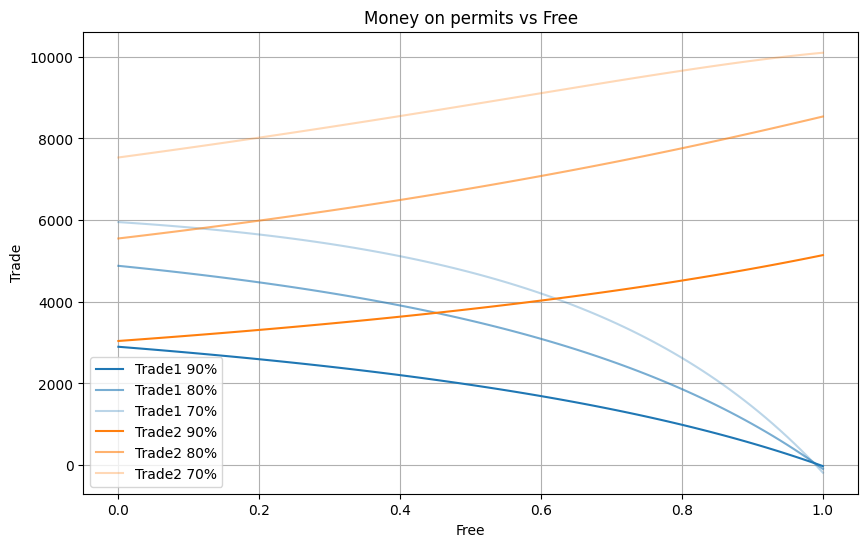

In [23]:
# Define colors and transparency levels
colors = {0.7: 'blue', 0.8: 'green', 0.9: 'red'}
alphas = {0.7: 0.3, 0.8: 0.6, 0.9: 1.0}

# Plot trades1 and trades2 with respect to frees
plt.figure(figsize=(10, 6))
for perc in [0.9, 0.8, 0.7]: plt.plot(frees, results[perc]['trades1'], label=f'Trade1 {perc*100:.0f}%', color='#1f77b4', alpha=alphas[perc]) 
for perc in [0.9, 0.8, 0.7]: plt.plot(frees, results[perc]['trades2'], label=f'Trade2 {perc*100:.0f}%', color='#ff7f0e', alpha=alphas[perc])
plt.xlabel('Free')
plt.ylabel('Trade')
plt.title('Money on permits vs Free')
plt.legend()
plt.grid()
plt.show()


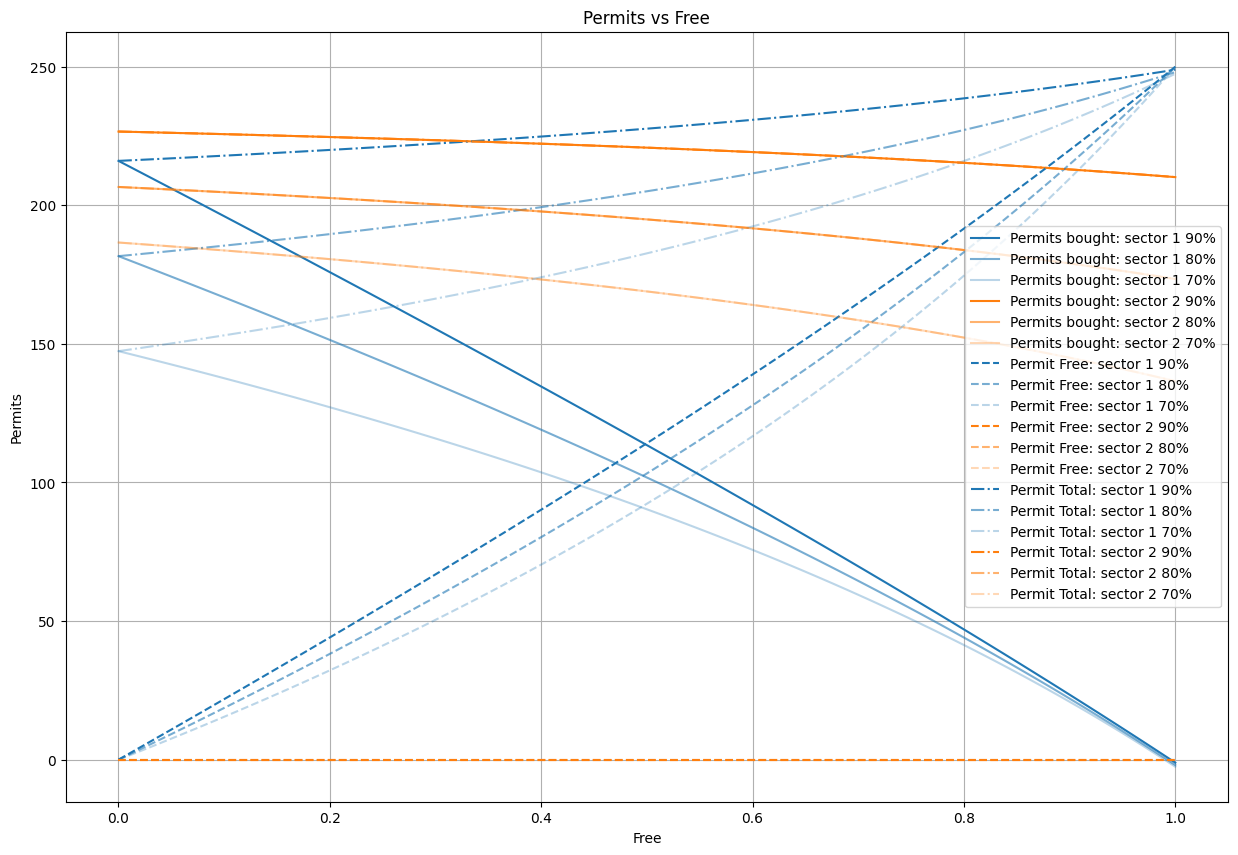

In [18]:
# Define colors and transparency levels
colors = {'b': '#1f77b4', 'o': '#ff7f0e'}
alphas = {0.7: 0.3, 0.8: 0.6, 0.9: 1.0}

# Plot permits bought, free, and used for each percentage
plt.figure(figsize=(15, 10))
for perc in [0.9, 0.8, 0.7]: plt.plot(frees, results[perc]['permits_bought_1'], label=f'Permits bought: sector 1 {perc*100:.0f}%', color=colors['b'], alpha=alphas[perc])
for perc in [0.9, 0.8, 0.7]:plt.plot(frees, results[perc]['permits_bought_2'], label=f'Permits bought: sector 2 {perc*100:.0f}%', color=colors['o'], alpha=alphas[perc])
for perc in [0.9, 0.8, 0.7]:plt.plot(frees, results[perc]['permits_free_1'], label=f'Permit Free: sector 1 {perc*100:.0f}%', color=colors['b'], linestyle='--', alpha=alphas[perc])
for perc in [0.9, 0.8, 0.7]:plt.plot(frees, results[perc]['permits_free_2'], label=f'Permit Free: sector 2 {perc*100:.0f}%', color=colors['o'], linestyle='--', alpha=alphas[perc])
for perc in [0.9, 0.8, 0.7]:plt.plot(frees, results[perc]['permits_used_1'], label=f'Permit Total: sector 1 {perc*100:.0f}%', color=colors['b'], linestyle='-.', alpha=alphas[perc])
for perc in [0.9, 0.8, 0.7]:plt.plot(frees, results[perc]['permits_used_2'], label=f'Permit Total: sector 2 {perc*100:.0f}%', color=colors['o'], linestyle='-.', alpha=alphas[perc])

plt.xlabel('Free')
plt.ylabel('Permits')
plt.title('Permits vs Free')
plt.legend()
plt.grid()
plt.show()

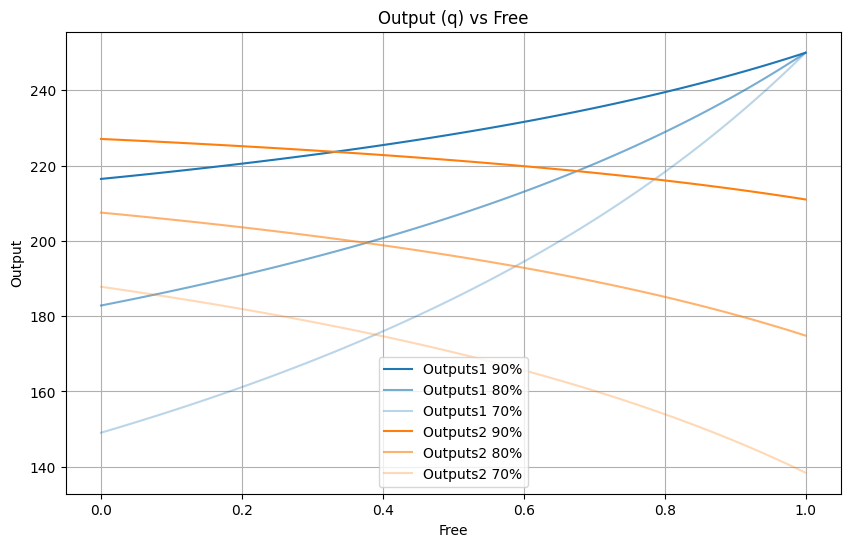

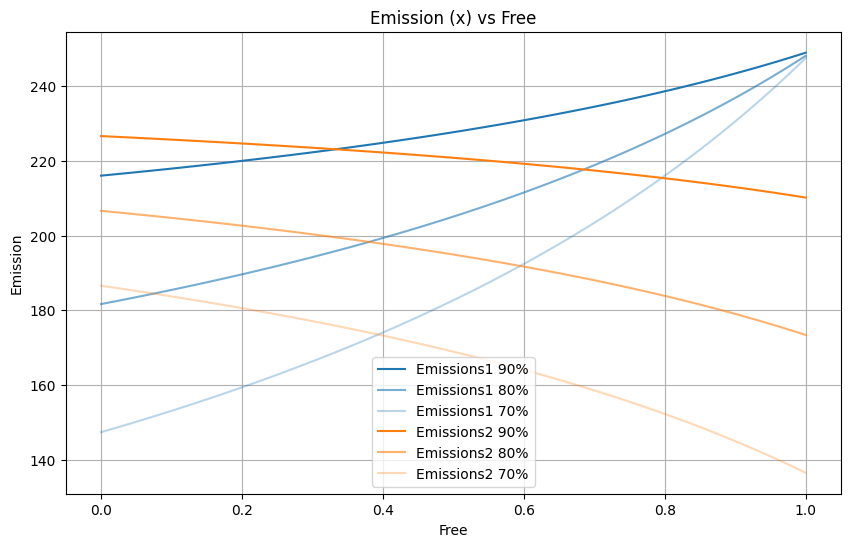

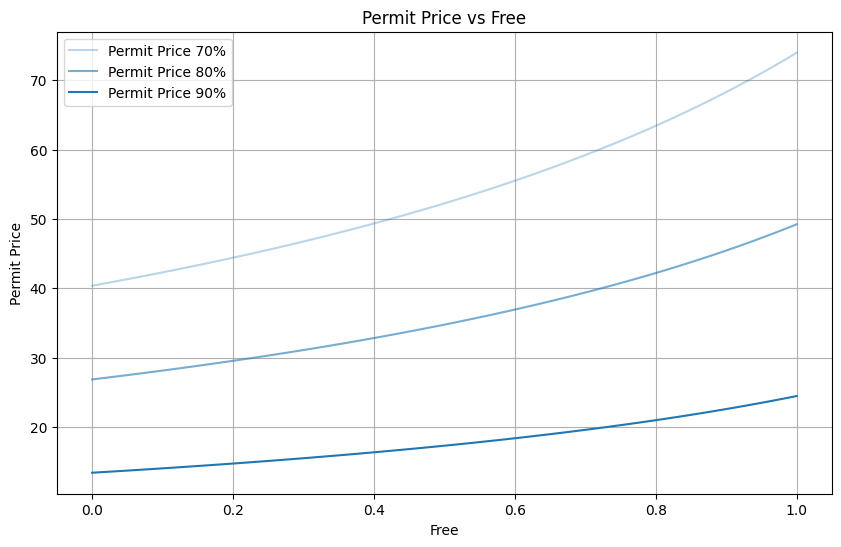

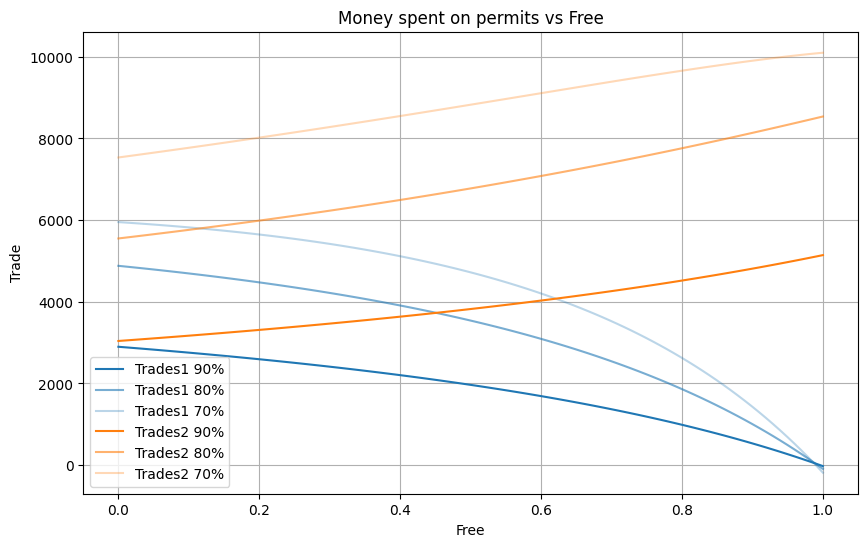

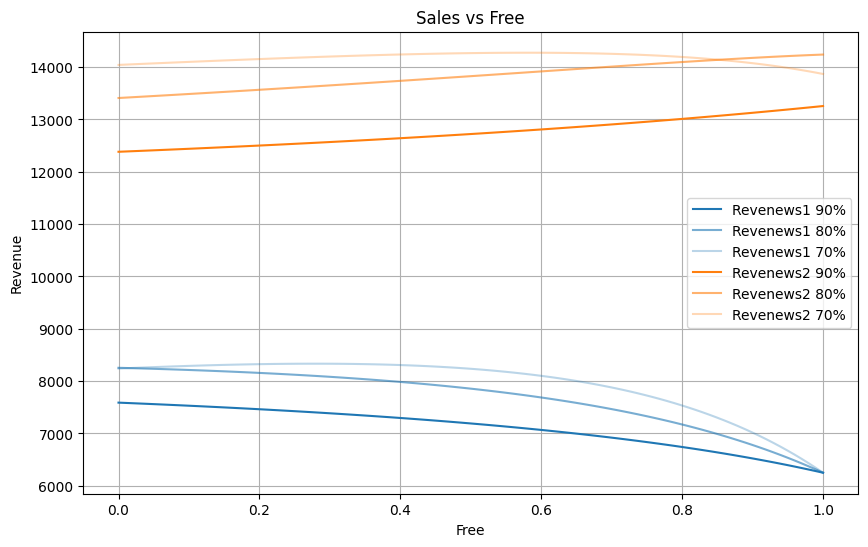

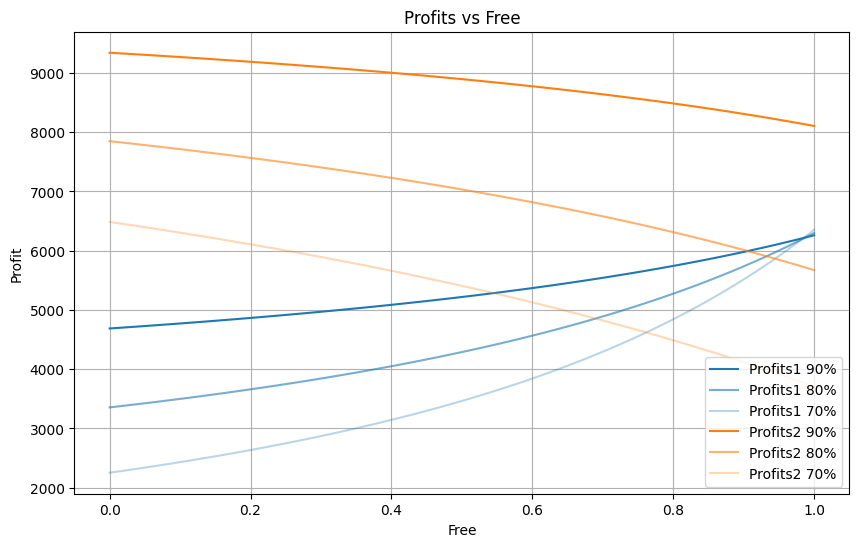

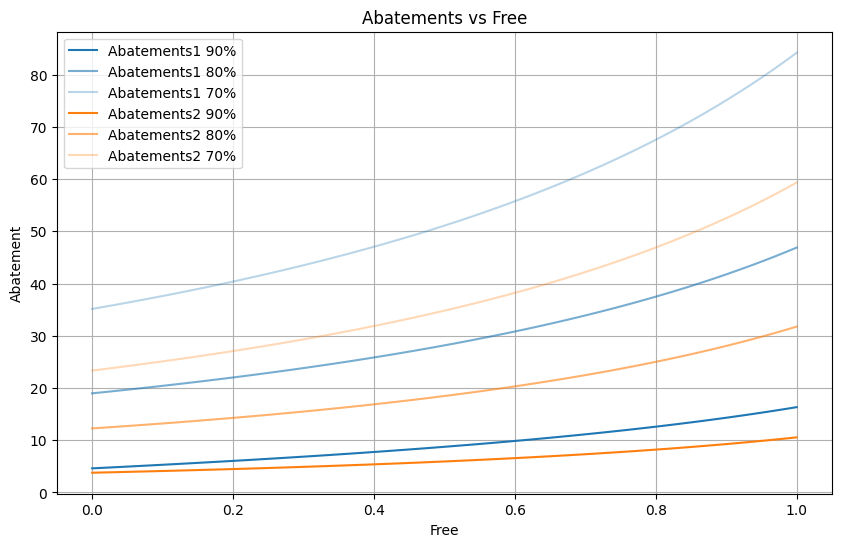

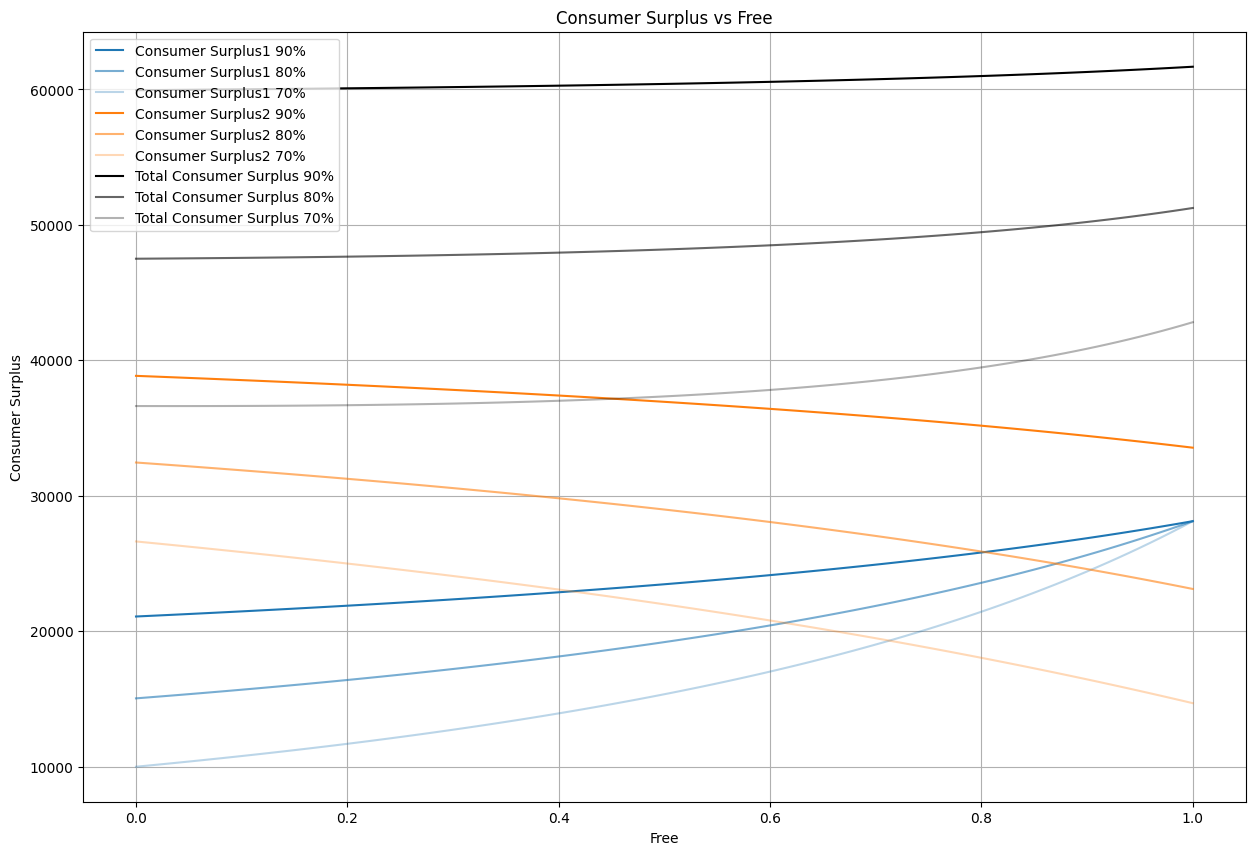

In [27]:
# Define colors and transparency levels
colors = {'trades1': '#1f77b4', 'trades2': '#ff7f0e'}
alphas = {0.7: 0.3, 0.8: 0.6, 0.9: 1.0}

# Define a function to plot the metrics
def plot_metric(metric, ylabel, title):
    plt.figure(figsize=(10, 6))
    for perc in [0.9, 0.8, 0.7]: plt.plot(frees, results[perc][f'{metric}1'], label=f'{metric.capitalize()}1 {perc*100:.0f}%', color=colors['trades1'], alpha=alphas[perc])
    for perc in [0.9, 0.8, 0.7]: plt.plot(frees, results[perc][f'{metric}2'], label=f'{metric.capitalize()}2 {perc*100:.0f}%', color=colors['trades2'], alpha=alphas[perc])
    plt.xlabel('Free')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

# Plot outputs
plot_metric('outputs', 'Output', 'Output (q) vs Free')

# Plot emissions
plot_metric('emissions', 'Emission', 'Emission (x) vs Free')

# Plot permit prices
plt.figure(figsize=(10, 6))
for perc in [0.7, 0.8, 0.9]:
    plt.plot(frees, results[perc]['permit_price'], label=f'Permit Price {perc*100:.0f}%', color=colors['trades1'], alpha=alphas[perc])
plt.xlabel('Free')
plt.ylabel('Permit Price')
plt.title('Permit Price vs Free')
plt.legend()
plt.grid()
plt.show()

# Plot trades
plot_metric('trades', 'Trade', 'Money spent on permits vs Free')

# Plot revenues
plot_metric('revenews', 'Revenue', 'Sales vs Free')



# Plot profits
plot_metric('profits', 'Profit', 'Profits vs Free')

# Plot abatements
plot_metric('abatements', 'Abatement', 'Abatements vs Free')

# Plot consumer surplus
# plot_metric('consumer_surplus_', 'Consumer Surplus', 'Consumer Surplus vs Free')
#plot consumer surplus
from operator import add
plt.figure(figsize=(15, 10))
for perc in [0.9, 0.8, 0.7]: plt.plot(frees, results[perc]['consumer_surplus_1'], label=f'Consumer Surplus1 {perc*100:.0f}%', color=colors['trades1'], alpha=alphas[perc])
for perc in [0.9, 0.8, 0.7]: plt.plot(frees, results[perc]['consumer_surplus_2'], label=f'Consumer Surplus2 {perc*100:.0f}%', color=colors['trades2'], alpha=alphas[perc])
for perc in [0.9, 0.8, 0.7]: plt.plot(frees, list( map(add,results[perc]['consumer_surplus_1'], results[perc]['consumer_surplus_2'])), label=f'Total Consumer Surplus {perc*100:.0f}%', color='black', alpha=alphas[perc])
plt.xlabel('Free')
plt.ylabel('Consumer Surplus')
plt.title('Consumer Surplus vs Free')
plt.legend()
plt.grid()
plt.show()

